In [1]:
import numpy as np
import pandas as pd
import re
import time
import torch
import torch.nn as nn
import wandb
import random
import math
import itertools
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification, BertPreTrainedModel, Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from kaggle_secrets import UserSecretsClient

In [2]:
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_key")
wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [4]:
train_data = pd.read_csv('/kaggle/input/netifier/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [5]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [6]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [7]:
train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


In [8]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
# Define compute metrics for evaluation
def compute_metrics(p):
    preds = torch.sigmoid(torch.tensor(p.predictions)).round()  # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)
    
    accuracy = accuracy_score(labels, preds)

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    a, b, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
    }

In [10]:
# Define compute metrics for evaluation
def compute_metrics_eval(p):
    result = compute_metrics(p)
    
    preds = torch.sigmoid(torch.tensor(p.predictions)).round()  # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)
    
    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    )    
    return {
        'accuracy': result['accuracy'],
        'precision': result['precision'],
        'recall': result['recall'],
        'f1_micro': result['f1_micro'],
        'f1_macro': result['f1_macro'],
        'report': report
    }

# ACTIVE LEARNING LOOP

In [11]:
accuracies = []
f1_micros = []
f1_macros = []
sampling_dur = []
data_used = []

In [12]:
filename = 'netifier-lc'
epochs = 10
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
def least_confidence_sampling(model, X_pool, train_indices, remaining_indices, trials, n_samples=min_increment):
    start_time = time.time()
    current_train_size = len(train_indices)
        
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=128)
    dataloader = DataLoader(
        dataset,
        batch_size=16,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    uncertainties = []
    for data in dataloader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits

        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)

    uncertainties = np.array(uncertainties)
    sorted = np.argsort(uncertainties)
    sorted = sorted[::-1]

    threshold = np.percentile(uncertainties, 90)
    items_greater_than_average = uncertainties[uncertainties >= threshold]
    num_of_candidates = len(items_greater_than_average)

    # Check nearest checkpoint
    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break
            
    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        least_confident_indices = sorted[:n_samples]
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
         least_confident_indices = sorted[:num_of_candidates]
    else:
        least_confident_indices = sorted[:nearest_cp - current_train_size]

        temp = train_indices.copy()
        temp.extend(least_confident_indices)
        
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'pornografi': [y_train[i][0] for i in temp],
            'sara': [y_train[i][1] for i in temp],
            'radikalisme': [y_train[i][2] for i in temp],
            'pencemaran_nama_baik': [y_train[i][3] for i in temp],
        })

        acquired_data.to_csv(f'{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time()  # Record the end time
    duration = end_time - start_time  # Calculate the duration in seconds

    print("Nearest checkpoint:", nearest_cp)
    print("Threshold:", threshold)
    print("Samples above threshold:", num_of_candidates)
    print("Acquired samples:", len(least_confident_indices))
    print(f"Sampling duration: {duration} seconds")  # Print or return the runtime if needed
    
    sampling_dur.append(duration)
    
    return [remaining_indices[i] for i in least_confident_indices]

In [14]:
def train_model(current_train_size, train_indices, trials, seed):
    model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        # Specify the layers you want to freeze (e.g., first 6 layers)
        if "encoder.layer" in name:
            # Extract the layer number safely
            layer_num = name.split(".")[3]
            try:
                # Freeze only the first 6 layers
                if int(layer_num) < 9:
                    param.requires_grad = False
            except ValueError:
                # Skip any parameter names that don’t follow the expected format
                continue
    
    # Create Dataset with current training data
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_dataset = NetifierDataset(current_X_train, current_y_train, tokenizer, max_length=128)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=128)
    
    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f'./results/{filename}-{trials+1}',
        eval_strategy="epoch",                    # Evaluate after every epoch
        save_strategy="epoch",                    # Save model after every epoch
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='f1_micro',
        save_total_limit=1,
        seed=seed
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

    # Evaluate after training
    trainer.compute_metrics = compute_metrics_eval
    eval_results = trainer.evaluate()
    print(f"Iteration {current_train_size}: Accuracy: {eval_results['eval_accuracy']}, F1 Micro: {eval_results['eval_f1_micro']}, F1 Macro: {eval_results['eval_f1_macro']}")
    print(eval_results['eval_report'])

    torch.save(model.state_dict(), f'{filename}-{trials+1}-model.pth')
    model.config.to_json_file(f'{filename}-{trials+1}-config.json')

    data_used.append(current_train_size)
    accuracies.append(eval_results['eval_accuracy'])
    f1_micros.append(eval_results['eval_f1_micro'])
    f1_macros.append(eval_results['eval_f1_macro'])
    
    return model, trainer

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))

    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [16]:
def active_learning(seed, i):
    accuracies.clear()
    f1_micros.clear()
    f1_macros.clear()
    sampling_dur.clear()
    data_used.clear()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model, trainer = train_model(current_train_size, train_indices, i, seed)
    
        # Perform query strategy to select new samples
        new_samples = least_confidence_sampling(
            model, 
            [X_train[i] for i in remaining_indices], 
            train_indices,
            remaining_indices,
            trials=i, 
        )
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model, trainer = train_model(current_train_size, train_indices, i, seed)
    
    end_time = time.time()
    duration = end_time - start_time  # Calculate the duration in seconds
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    sampling_dur.insert(0, 0)
    
    results['Sampling Duration'] = sampling_dur
    
    results.to_csv(f'{filename}-{i+1}-results.csv', index=False)

In [17]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: nicost918 (nicost918-petra-christian-university). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241217_125552-8vim52ye
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results/netifier-lc-1
wandb: ⭐️ View project at https://wandb.ai/nicost918-petra-christian-university/huggingface
wandb: 🚀 View run at https://wandb.

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.471070,0.441801,0.722222,0.009804,0.019345,0.016121
2,No log,0.408955,0.549839,0.937743,0.181750,0.304485,0.212706
3,No log,0.356134,0.570418,0.760807,0.398190,0.522772,0.458811
4,No log,0.333005,0.578135,0.745169,0.465309,0.572888,0.519570
5,No log,0.328695,0.599357,0.754325,0.493213,0.596443,0.562729
6,No log,0.316878,0.602572,0.734064,0.555807,0.632618,0.600391
7,No log,0.322708,0.605788,0.756849,0.500000,0.602180,0.576849
8,No log,0.310757,0.618006,0.728030,0.593514,0.653926,0.632917
9,No log,0.310798,0.616720,0.731638,0.585973,0.650754,0.631457
10,No log,0.310642,0.616077,0.733840,0.582202,0.649285,0.630442


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.80      0.85       362
                sara       0.62      0.32      0.42       237
         radikalisme       0.69      0.66      0.68       235
pencemaran_nama_baik       0.64      0.54      0.59       492

           micro avg       0.73      0.59      0.65      1326
           macro avg       0.71      0.58      0.63      1326
        weighted avg       0.72      0.59      0.64      1326
         samples avg       0.35      0.33      0.33      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.6180064308681672, F1 Micro: 0.653926049023681, F1 Macro: 0.6329171582051338
                      precision    recall  f1-score   support

          pornografi       0.90      0.80      0.85       362
                sara       0.62      0.32      0.42       237
         radikalisme       0.69      0.66      0.68       235
pencemaran_nama_baik       0.64      0.54      0.59       492

           micro avg       0.73      0.59      0.65      1326
           macro avg       0.71      0.58      0.63      1326
        weighted avg       0.72      0.59      0.64      1326
         samples avg       0.35      0.33      0.33      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.8939410455524921
Samples above threshold: 583
Acquired samples: 583
Sampling duration: 20.06878662109375 seconds
New train size: 971


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.430060,0.547267,0.917647,0.176471,0.296015,0.212407
2,No log,0.339294,0.571704,0.735065,0.426848,0.540076,0.509811
3,No log,0.320608,0.597428,0.751387,0.510558,0.607993,0.576728
4,No log,0.303444,0.611576,0.709402,0.625943,0.665064,0.657531
5,No log,0.302950,0.618650,0.718127,0.624434,0.668011,0.661997
6,No log,0.299793,0.628939,0.723001,0.661388,0.690823,0.675127
7,No log,0.302168,0.631511,0.734144,0.637255,0.682277,0.672745
8,No log,0.305015,0.637299,0.726073,0.663650,0.693459,0.684938
9,0.180100,0.308608,0.632154,0.729958,0.652338,0.688969,0.678106
10,0.180100,0.308172,0.629582,0.715773,0.674208,0.694369,0.685902


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.84      0.87       362
                sara       0.64      0.51      0.57       237
         radikalisme       0.65      0.70      0.67       235
pencemaran_nama_baik       0.65      0.62      0.63       492

           micro avg       0.72      0.67      0.69      1326
           macro avg       0.71      0.67      0.69      1326
        weighted avg       0.72      0.67      0.69      1326
         samples avg       0.38      0.38      0.37      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 971: Accuracy: 0.6295819935691318, F1 Micro: 0.6943689320388349, F1 Macro: 0.6859024981598474
                      precision    recall  f1-score   support

          pornografi       0.90      0.84      0.87       362
                sara       0.64      0.51      0.57       237
         radikalisme       0.65      0.70      0.67       235
pencemaran_nama_baik       0.65      0.62      0.63       492

           micro avg       0.72      0.67      0.69      1326
           macro avg       0.71      0.67      0.69      1326
        weighted avg       0.72      0.67      0.69      1326
         samples avg       0.38      0.38      0.37      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.9412037670612335
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 18.11165428161621 seconds
New train size: 1496


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.444531,0.553055,0.951020,0.175716,0.296626,0.209635
2,No log,0.317681,0.588424,0.725971,0.535445,0.616319,0.591499
3,No log,0.298519,0.615434,0.714534,0.619155,0.663434,0.646247
4,No log,0.288986,0.643087,0.709285,0.702866,0.706061,0.689479
5,No log,0.300154,0.635370,0.675265,0.769985,0.719521,0.713264
6,0.168800,0.310835,0.648875,0.681546,0.771493,0.723735,0.716161
7,0.168800,0.317864,0.649518,0.691881,0.751885,0.720636,0.714370
8,0.168800,0.317229,0.650804,0.710273,0.724736,0.717432,0.708992
9,0.168800,0.327822,0.654019,0.696949,0.757919,0.726156,0.720694
10,0.168800,0.326194,0.648875,0.699858,0.742081,0.720351,0.713864


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.88      0.87      0.87       362
                sara       0.61      0.62      0.61       237
         radikalisme       0.64      0.81      0.72       235
pencemaran_nama_baik       0.65      0.72      0.68       492

           micro avg       0.70      0.76      0.73      1326
           macro avg       0.69      0.75      0.72      1326
        weighted avg       0.70      0.76      0.73      1326
         samples avg       0.41      0.43      0.41      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1496: Accuracy: 0.6540192926045016, F1 Micro: 0.7261560693641619, F1 Macro: 0.7206935807694668
                      precision    recall  f1-score   support

          pornografi       0.88      0.87      0.87       362
                sara       0.61      0.62      0.61       237
         radikalisme       0.64      0.81      0.72       235
pencemaran_nama_baik       0.65      0.72      0.68       492

           micro avg       0.70      0.76      0.73      1326
           macro avg       0.69      0.75      0.72      1326
        weighted avg       0.70      0.76      0.73      1326
         samples avg       0.41      0.43      0.41      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.9351345762610437
Samples above threshold: 473
Acquired samples: 473
Sampling duration: 16.414743423461914 seconds
New train size: 1969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.395400,0.556913,0.922794,0.189291,0.314143,0.231689
2,No log,0.306682,0.615434,0.729167,0.580694,0.646516,0.644855
3,No log,0.291905,0.646302,0.745975,0.628959,0.682488,0.679743
4,No log,0.283922,0.642444,0.711242,0.730015,0.720506,0.707808
5,0.169600,0.294481,0.642444,0.698413,0.763198,0.729369,0.718950
6,0.169600,0.297530,0.664309,0.722182,0.748869,0.735283,0.729003
7,0.169600,0.330426,0.651447,0.673125,0.812217,0.736159,0.732548
8,0.169600,0.321816,0.655949,0.693083,0.778281,0.733215,0.725230
9,0.062800,0.320501,0.665595,0.710600,0.768477,0.738406,0.731188
10,0.062800,0.325742,0.655305,0.706454,0.767722,0.735815,0.728271


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.85      0.87       362
                sara       0.62      0.63      0.63       237
         radikalisme       0.64      0.81      0.72       235
pencemaran_nama_baik       0.67      0.76      0.71       492

           micro avg       0.71      0.77      0.74      1326
           macro avg       0.71      0.76      0.73      1326
        weighted avg       0.72      0.77      0.74      1326
         samples avg       0.42      0.43      0.41      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1969: Accuracy: 0.6655948553054662, F1 Micro: 0.7384057971014492, F1 Macro: 0.731187924629885
                      precision    recall  f1-score   support

          pornografi       0.90      0.85      0.87       362
                sara       0.62      0.63      0.63       237
         radikalisme       0.64      0.81      0.72       235
pencemaran_nama_baik       0.67      0.76      0.71       492

           micro avg       0.71      0.77      0.74      1326
           macro avg       0.71      0.76      0.73      1326
        weighted avg       0.72      0.77      0.74      1326
         samples avg       0.42      0.43      0.41      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.8450943350791932
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 14.789022207260132 seconds
New train size: 2394


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.368044,0.560129,0.917492,0.209653,0.341314,0.269892
2,No log,0.297894,0.622508,0.730245,0.606335,0.662546,0.657983
3,No log,0.278159,0.659807,0.691205,0.800151,0.741699,0.732980
4,0.193400,0.273960,0.662379,0.696393,0.800905,0.745002,0.741277
5,0.193400,0.287126,0.663666,0.705961,0.794872,0.747783,0.733351
6,0.193400,0.289985,0.666238,0.723496,0.761689,0.742101,0.728466
7,0.084200,0.304783,0.672669,0.714383,0.794118,0.752143,0.744499
8,0.084200,0.323116,0.664309,0.692898,0.816742,0.749740,0.746410
9,0.084200,0.328052,0.667524,0.694087,0.814480,0.749480,0.743533
10,0.044900,0.322744,0.672026,0.705999,0.807692,0.753429,0.747798


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.89      0.89       362
                sara       0.61      0.69      0.65       237
         radikalisme       0.64      0.85      0.73       235
pencemaran_nama_baik       0.67      0.79      0.72       492

           micro avg       0.71      0.81      0.75      1326
           macro avg       0.70      0.80      0.75      1326
        weighted avg       0.71      0.81      0.76      1326
         samples avg       0.43      0.46      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2394: Accuracy: 0.6720257234726688, F1 Micro: 0.7534294759057334, F1 Macro: 0.7477977564913787
                      precision    recall  f1-score   support

          pornografi       0.89      0.89      0.89       362
                sara       0.61      0.69      0.65       237
         radikalisme       0.64      0.85      0.73       235
pencemaran_nama_baik       0.67      0.79      0.72       492

           micro avg       0.71      0.81      0.75      1326
           macro avg       0.70      0.80      0.75      1326
        weighted avg       0.71      0.81      0.76      1326
         samples avg       0.43      0.46      0.43      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.4966639518737797
Samples above threshold: 383
Acquired samples: 383
Sampling duration: 13.292513608932495 seconds
New train size: 2777


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.361897,0.567846,0.934028,0.202866,0.333333,0.231644
2,No log,0.282932,0.648232,0.724741,0.687029,0.705381,0.703441
3,0.210100,0.261633,0.673312,0.728190,0.761689,0.744563,0.735141
4,0.210100,0.291983,0.657878,0.677914,0.833333,0.747632,0.741765
5,0.210100,0.283353,0.686817,0.739354,0.759427,0.749256,0.747094
6,0.102200,0.295674,0.681672,0.723361,0.798643,0.759140,0.754831
7,0.102200,0.327558,0.663023,0.688085,0.831825,0.753158,0.751207
8,0.102200,0.322236,0.671383,0.716216,0.799397,0.755524,0.750439
9,0.054200,0.324897,0.671383,0.708936,0.813725,0.757725,0.755100
10,0.054200,0.324732,0.675241,0.712583,0.811463,0.758815,0.754950


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.88      0.89       362
                sara       0.61      0.70      0.65       237
         radikalisme       0.70      0.82      0.75       235
pencemaran_nama_baik       0.68      0.78      0.72       492

           micro avg       0.72      0.80      0.76      1326
           macro avg       0.72      0.79      0.75      1326
        weighted avg       0.73      0.80      0.76      1326
         samples avg       0.43      0.45      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2777: Accuracy: 0.6816720257234726, F1 Micro: 0.7591397849462367, F1 Macro: 0.7548309896426588
                      precision    recall  f1-score   support

          pornografi       0.91      0.88      0.89       362
                sara       0.61      0.70      0.65       237
         radikalisme       0.70      0.82      0.75       235
pencemaran_nama_baik       0.68      0.78      0.72       492

           micro avg       0.72      0.80      0.76      1326
           macro avg       0.72      0.79      0.75      1326
        weighted avg       0.73      0.80      0.76      1326
         samples avg       0.43      0.45      0.43      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.31896644830703735
Samples above threshold: 345
Acquired samples: 345
Sampling duration: 12.005959033966064 seconds
New train size: 3122


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.353038,0.564630,0.927052,0.230015,0.368580,0.296615
2,No log,0.277308,0.661093,0.705640,0.773756,0.738129,0.731974
3,0.230500,0.271617,0.689389,0.714096,0.809955,0.759011,0.750063
4,0.230500,0.265727,0.702251,0.734397,0.798643,0.765173,0.758403
5,0.230500,0.274007,0.702251,0.733562,0.807692,0.768844,0.762147
6,0.124000,0.349216,0.663666,0.662864,0.876320,0.754791,0.753547
7,0.124000,0.312733,0.684887,0.714941,0.822775,0.765077,0.759186
8,0.067900,0.314725,0.690032,0.723190,0.813725,0.765791,0.760945
9,0.067900,0.336217,0.685531,0.708974,0.834087,0.766459,0.762287
10,0.067900,0.340945,0.684244,0.707851,0.829563,0.763889,0.759355


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.88      0.90       362
                sara       0.61      0.67      0.64       237
         radikalisme       0.69      0.86      0.77       235
pencemaran_nama_baik       0.69      0.80      0.74       492

           micro avg       0.73      0.81      0.77      1326
           macro avg       0.73      0.80      0.76      1326
        weighted avg       0.74      0.81      0.77      1326
         samples avg       0.44      0.46      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3122: Accuracy: 0.7022508038585209, F1 Micro: 0.7688442211055275, F1 Macro: 0.762147159996968
                      precision    recall  f1-score   support

          pornografi       0.92      0.88      0.90       362
                sara       0.61      0.67      0.64       237
         radikalisme       0.69      0.86      0.77       235
pencemaran_nama_baik       0.69      0.80      0.74       492

           micro avg       0.73      0.81      0.77      1326
           macro avg       0.73      0.80      0.76      1326
        weighted avg       0.74      0.81      0.77      1326
         samples avg       0.44      0.46      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.1815493404865265
Samples above threshold: 310
Acquired samples: 310
Sampling duration: 10.889323472976685 seconds
New train size: 3432


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.311680,0.614148,0.806536,0.465309,0.590148,0.531331
2,No log,0.265001,0.677170,0.750000,0.714932,0.732046,0.721027
3,0.250400,0.263493,0.675884,0.746404,0.743590,0.744994,0.728994
4,0.250400,0.267242,0.695820,0.728268,0.802413,0.763545,0.758431
5,0.142200,0.275202,0.693248,0.730559,0.807692,0.767192,0.763385
6,0.142200,0.322318,0.690032,0.694360,0.863499,0.769748,0.770128
7,0.089000,0.306942,0.686817,0.715036,0.821267,0.764479,0.760345
8,0.089000,0.312815,0.688746,0.718915,0.819759,0.766032,0.761905
9,0.089000,0.312694,0.703537,0.741620,0.800905,0.770123,0.763547
10,0.057000,0.331212,0.699035,0.723179,0.823529,0.770099,0.764885


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.66      0.64      0.65       237
         radikalisme       0.71      0.84      0.77       235
pencemaran_nama_baik       0.69      0.78      0.73       492

           micro avg       0.74      0.80      0.77      1326
           macro avg       0.74      0.79      0.76      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3432: Accuracy: 0.7035369774919614, F1 Micro: 0.770123277737491, F1 Macro: 0.763546903169527
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.66      0.64      0.65       237
         radikalisme       0.71      0.84      0.77       235
pencemaran_nama_baik       0.69      0.78      0.73       492

           micro avg       0.74      0.80      0.77      1326
           macro avg       0.74      0.79      0.76      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.04258209466934204
Samples above threshold: 279
Acquired samples: 279
Sampling duration: 9.874484539031982 seconds
New train size: 3711


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.302163,0.618650,0.754774,0.566365,0.647135,0.636297
2,No log,0.259614,0.690675,0.727528,0.781297,0.753455,0.751089
3,0.263900,0.248928,0.697749,0.783034,0.723982,0.752351,0.732038
4,0.263900,0.282179,0.686174,0.705323,0.839367,0.766529,0.762097
5,0.157700,0.271534,0.702894,0.728486,0.823529,0.773097,0.769285
6,0.157700,0.284491,0.699678,0.755459,0.782805,0.768889,0.759610
7,0.101900,0.303813,0.703537,0.729514,0.825792,0.774673,0.767822
8,0.101900,0.318518,0.698392,0.727513,0.829563,0.775194,0.770804
9,0.068100,0.320574,0.697749,0.723572,0.831071,0.773605,0.770642
10,0.068100,0.315618,0.699678,0.734007,0.822021,0.775525,0.771632


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.61      0.71      0.65       237
         radikalisme       0.71      0.86      0.78       235
pencemaran_nama_baik       0.69      0.79      0.74       492

           micro avg       0.73      0.82      0.78      1326
           macro avg       0.73      0.82      0.77      1326
        weighted avg       0.74      0.82      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3711: Accuracy: 0.6996784565916399, F1 Micro: 0.775524724297403, F1 Macro: 0.7716322548725598
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.61      0.71      0.65       237
         radikalisme       0.71      0.86      0.78       235
pencemaran_nama_baik       0.69      0.79      0.74       492

           micro avg       0.73      0.82      0.78      1326
           macro avg       0.73      0.82      0.77      1326
        weighted avg       0.74      0.82      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.020580208301544195
Samples above threshold: 251
Acquired samples: 175
Sampling duration: 8.973403453826904 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.284924,0.641801,0.747871,0.662142,0.702400,0.693386
2,No log,0.255493,0.678457,0.733475,0.778281,0.755214,0.747518
3,0.271500,0.263090,0.688746,0.703537,0.825038,0.759459,0.757594
4,0.271500,0.267779,0.698392,0.718301,0.828808,0.769608,0.764152
5,0.165000,0.279678,0.702894,0.736044,0.805430,0.769175,0.759496
6,0.165000,0.285163,0.702894,0.740896,0.797888,0.768337,0.761148
7,0.107400,0.321830,0.694534,0.715120,0.831071,0.768748,0.765593
8,0.107400,0.322276,0.695177,0.722623,0.831071,0.773062,0.769385
9,0.071200,0.326271,0.697106,0.727092,0.825792,0.773305,0.768243
10,0.071200,0.327422,0.698392,0.726547,0.823529,0.772004,0.767835


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.88      0.91      0.90       362
                sara       0.61      0.69      0.65       237
         radikalisme       0.72      0.88      0.79       235
pencemaran_nama_baik       0.69      0.80      0.74       492

           micro avg       0.73      0.83      0.77      1326
           macro avg       0.72      0.82      0.77      1326
        weighted avg       0.73      0.83      0.78      1326
         samples avg       0.46      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.6971061093247588, F1 Micro: 0.7733050847457626, F1 Macro: 0.768243030341341
                      precision    recall  f1-score   support

          pornografi       0.88      0.91      0.90       362
                sara       0.61      0.69      0.65       237
         radikalisme       0.72      0.88      0.79       235
pencemaran_nama_baik       0.69      0.80      0.74       492

           micro avg       0.73      0.83      0.77      1326
           macro avg       0.72      0.82      0.77      1326
        weighted avg       0.73      0.83      0.78      1326
         samples avg       0.46      0.47      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.013772147893905639
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 8.316777229309082 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.277304,0.670740,0.788826,0.628205,0.699412,0.696834
2,0.284900,0.244901,0.699678,0.760212,0.757919,0.759063,0.750879
3,0.284900,0.244080,0.699678,0.763457,0.759427,0.761437,0.751108
4,0.176400,0.256684,0.690675,0.736510,0.792609,0.763531,0.759044
5,0.176400,0.269360,0.691318,0.742715,0.788084,0.764727,0.759271
6,0.115100,0.309880,0.684887,0.711613,0.831825,0.767038,0.762925
7,0.115100,0.313230,0.691961,0.722661,0.827300,0.771449,0.769272
8,0.081100,0.309231,0.702894,0.744905,0.799397,0.771190,0.764831
9,0.081100,0.312934,0.697106,0.745896,0.788084,0.766410,0.759581
10,0.061500,0.324508,0.694534,0.731241,0.808446,0.767908,0.762340


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.90       362
                sara       0.62      0.73      0.67       237
         radikalisme       0.69      0.88      0.77       235
pencemaran_nama_baik       0.68      0.80      0.73       492

           micro avg       0.72      0.83      0.77      1326
           macro avg       0.72      0.83      0.77      1326
        weighted avg       0.73      0.83      0.77      1326
         samples avg       0.45      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.6919614147909968, F1 Micro: 0.7714486638537271, F1 Macro: 0.7692721011509679
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.90       362
                sara       0.62      0.73      0.67       237
         radikalisme       0.69      0.88      0.77       235
pencemaran_nama_baik       0.68      0.80      0.73       492

           micro avg       0.72      0.83      0.77      1326
           macro avg       0.72      0.83      0.77      1326
        weighted avg       0.73      0.83      0.77      1326
         samples avg       0.45      0.47      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.010799241065979005
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 7.514275074005127 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.284154,0.639228,0.834577,0.506033,0.630047,0.629777
2,0.292000,0.245633,0.694534,0.741661,0.788084,0.764168,0.756294
3,0.292000,0.247473,0.703537,0.743785,0.812217,0.776496,0.767355
4,0.186000,0.247310,0.704180,0.740638,0.805430,0.771676,0.768258
5,0.186000,0.273816,0.693248,0.732203,0.814480,0.771153,0.763920
6,0.129100,0.300011,0.687460,0.719035,0.831825,0.771329,0.767341
7,0.129100,0.290749,0.707395,0.752680,0.794118,0.772844,0.767870
8,0.090400,0.301104,0.707395,0.750000,0.800905,0.774617,0.768011
9,0.090400,0.311729,0.705466,0.741869,0.808446,0.773728,0.768644
10,0.068300,0.311279,0.704823,0.745480,0.808446,0.775687,0.770756


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.89      0.90       362
                sara       0.66      0.60      0.63       237
         radikalisme       0.73      0.85      0.79       235
pencemaran_nama_baik       0.68      0.84      0.75       492

           micro avg       0.74      0.81      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.7035369774919614, F1 Micro: 0.7764960346070656, F1 Macro: 0.7673547956029148
                      precision    recall  f1-score   support

          pornografi       0.92      0.89      0.90       362
                sara       0.66      0.60      0.63       237
         radikalisme       0.73      0.85      0.79       235
pencemaran_nama_baik       0.68      0.84      0.75       492

           micro avg       0.74      0.81      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.10236265659332275
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 6.792560577392578 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.276580,0.644373,0.720947,0.734540,0.727680,0.721137
2,0.300700,0.247875,0.689389,0.751673,0.762443,0.757020,0.749723
3,0.300700,0.233549,0.714469,0.778204,0.764706,0.771396,0.766607
4,0.201000,0.246005,0.713183,0.755940,0.791855,0.773481,0.768329
5,0.201000,0.261566,0.701608,0.739876,0.812971,0.774704,0.768193
6,0.142500,0.284959,0.690675,0.728070,0.813725,0.768519,0.762416
7,0.142500,0.280434,0.713826,0.771277,0.765460,0.768357,0.761050
8,0.099500,0.299105,0.707395,0.749823,0.800151,0.774170,0.768857
9,0.075700,0.302665,0.708682,0.758345,0.788084,0.772929,0.766724
10,0.075700,0.304299,0.708039,0.757465,0.784314,0.770656,0.763696


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.71      0.85      0.77       235
pencemaran_nama_baik       0.68      0.80      0.74       492

           micro avg       0.74      0.81      0.77      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.74      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.7016077170418007, F1 Micro: 0.7747035573122529, F1 Macro: 0.7681926700698194
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.71      0.85      0.77       235
pencemaran_nama_baik       0.68      0.80      0.74       492

           micro avg       0.74      0.81      0.77      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.74      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.02220315337181091
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 6.248746871948242 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.270126,0.664309,0.802554,0.616139,0.697099,0.694367
2,0.306300,0.239068,0.698392,0.785301,0.717195,0.749704,0.739281
3,0.306300,0.239061,0.704180,0.812554,0.702866,0.753740,0.735125
4,0.204900,0.241813,0.708039,0.758447,0.795626,0.776592,0.769828
5,0.204900,0.256105,0.715756,0.784223,0.764706,0.774341,0.765262
6,0.147300,0.274316,0.709325,0.789600,0.744344,0.766304,0.758577
7,0.106300,0.284080,0.704823,0.764444,0.778281,0.771300,0.763699
8,0.106300,0.299550,0.696463,0.748212,0.788839,0.767988,0.762864
9,0.077300,0.303865,0.704823,0.763061,0.782051,0.772439,0.766361
10,0.077300,0.311196,0.701608,0.751073,0.791855,0.770925,0.765414


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.92      0.91       362
                sara       0.65      0.66      0.65       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.72      0.75      0.74       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.7080385852090032, F1 Micro: 0.7765918292234082, F1 Macro: 0.7698275637438274
                      precision    recall  f1-score   support

          pornografi       0.90      0.92      0.91       362
                sara       0.65      0.66      0.65       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.72      0.75      0.74       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.03510700464248661
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 5.626382827758789 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.266728,0.673955,0.761944,0.697587,0.728346,0.718069
2,0.310700,0.238433,0.704823,0.762649,0.773002,0.767790,0.762579
3,0.310700,0.231487,0.715756,0.766471,0.789593,0.777860,0.769323
4,0.209800,0.242554,0.701608,0.755906,0.796380,0.775615,0.770617
5,0.157600,0.253479,0.706752,0.775744,0.766968,0.771331,0.760219
6,0.157600,0.277848,0.700965,0.739782,0.819005,0.777380,0.772267
7,0.110300,0.289334,0.712540,0.750520,0.816742,0.782232,0.775063
8,0.110300,0.292517,0.715113,0.754916,0.810709,0.781818,0.776193
9,0.086000,0.293991,0.717685,0.774313,0.786576,0.780397,0.772960
10,0.068400,0.302753,0.718971,0.765004,0.797888,0.781100,0.774371


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.62      0.69      0.65       237
         radikalisme       0.70      0.87      0.78       235
pencemaran_nama_baik       0.72      0.79      0.75       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.74      0.81      0.78      1326
        weighted avg       0.76      0.82      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.712540192926045, F1 Micro: 0.7822318526543878, F1 Macro: 0.7750632037763763
                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.62      0.69      0.65       237
         radikalisme       0.70      0.87      0.78       235
pencemaran_nama_baik       0.72      0.79      0.75       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.74      0.81      0.78      1326
        weighted avg       0.76      0.82      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.012279927730560303
Samples above threshold: 165
Acquired samples: 200
Sampling duration: 4.946549415588379 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.270888,0.657878,0.703051,0.782051,0.740450,0.735470
2,0.308600,0.237450,0.702894,0.752540,0.782051,0.767012,0.757582
3,0.308600,0.246420,0.693891,0.747629,0.773002,0.760104,0.748630
4,0.206900,0.252564,0.693248,0.735294,0.791855,0.762527,0.754255
5,0.153400,0.260998,0.706109,0.755343,0.773002,0.764070,0.755370
6,0.153400,0.283485,0.701608,0.742392,0.791101,0.765973,0.756820
7,0.113500,0.292686,0.704823,0.750900,0.786576,0.768324,0.759905
8,0.083100,0.299365,0.708039,0.758876,0.773756,0.766243,0.754721
9,0.083100,0.303145,0.715756,0.778120,0.761689,0.769817,0.758826
10,0.068200,0.309013,0.702894,0.753285,0.778281,0.765579,0.754164


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.65      0.59      0.62       237
         radikalisme       0.73      0.81      0.77       235
pencemaran_nama_baik       0.75      0.71      0.73       492

           micro avg       0.78      0.76      0.77      1326
           macro avg       0.76      0.76      0.76      1326
        weighted avg       0.78      0.76      0.77      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.7157556270096463, F1 Micro: 0.7698170731707316, F1 Macro: 0.7588258730141089
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.65      0.59      0.62       237
         radikalisme       0.73      0.81      0.77       235
pencemaran_nama_baik       0.75      0.71      0.73       492

           micro avg       0.78      0.76      0.77      1326
           macro avg       0.76      0.76      0.76      1326
        weighted avg       0.78      0.76      0.77      1326
         samples avg       0.44      0.44      0.43      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.004261505603790286
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 4.304629802703857 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.257967,0.690032,0.718623,0.803167,0.758547,0.755142
2,0.303700,0.235552,0.698392,0.772939,0.749623,0.761103,0.740775
3,0.303700,0.233881,0.716399,0.793408,0.744344,0.768093,0.756550
4,0.214100,0.236839,0.718971,0.787316,0.767722,0.777396,0.769600
5,0.154000,0.259862,0.719614,0.751743,0.812971,0.781159,0.775017
6,0.154000,0.285728,0.720257,0.744027,0.822021,0.781082,0.773793
7,0.114100,0.281375,0.718328,0.775357,0.778281,0.776816,0.770016
8,0.084200,0.293111,0.712540,0.764620,0.788839,0.776540,0.771363
9,0.084200,0.306459,0.717042,0.769004,0.785822,0.777322,0.770064
10,0.065800,0.307962,0.718328,0.769287,0.789593,0.779308,0.772770


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.92       362
                sara       0.62      0.70      0.66       237
         radikalisme       0.71      0.87      0.78       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.74      0.81      0.78      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.7196141479099678, F1 Micro: 0.7811594202898552, F1 Macro: 0.7750173840308552
                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.92       362
                sara       0.62      0.70      0.66       237
         radikalisme       0.71      0.87      0.78       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.74      0.81      0.78      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.00831056833267212
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 3.684798240661621 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.256687,0.670740,0.716125,0.797134,0.754461,0.745300
2,0.311400,0.235128,0.712540,0.811694,0.711916,0.758538,0.742831
3,0.213800,0.257229,0.691318,0.710044,0.847662,0.772774,0.767969
4,0.213800,0.240665,0.709968,0.766983,0.791855,0.779221,0.770469
5,0.157600,0.255179,0.706752,0.755175,0.797888,0.775944,0.767704
6,0.120700,0.275851,0.709968,0.749477,0.809955,0.778543,0.771613
7,0.120700,0.284825,0.713183,0.763716,0.787330,0.775343,0.766605
8,0.090000,0.288995,0.711897,0.782101,0.757919,0.769820,0.759850
9,0.071100,0.297686,0.712540,0.766052,0.782805,0.774338,0.767092
10,0.071100,0.304379,0.712540,0.758967,0.797888,0.777941,0.772115


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.67      0.62      0.64       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.7099678456591639, F1 Micro: 0.7792207792207793, F1 Macro: 0.7704686470058046
                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.67      0.62      0.64       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.012228333950042724
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 2.9739387035369873 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.249420,0.697749,0.732862,0.782051,0.756658,0.755642
2,0.309100,0.224847,0.722186,0.771407,0.781297,0.776321,0.768378
3,0.215400,0.223211,0.724116,0.786697,0.776018,0.781321,0.770682
4,0.215400,0.239109,0.714469,0.752778,0.817496,0.783803,0.777246
5,0.160700,0.244877,0.723473,0.780147,0.800151,0.790022,0.782841
6,0.123600,0.259650,0.720257,0.773165,0.786576,0.779813,0.770402
7,0.123600,0.275604,0.722830,0.774481,0.787330,0.780853,0.772119
8,0.097300,0.290240,0.721543,0.769853,0.789593,0.779598,0.770992
9,0.074200,0.295690,0.721543,0.768452,0.800905,0.784343,0.777162
10,0.063800,0.302206,0.726045,0.770408,0.797134,0.783543,0.777558


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.90      0.93       362
                sara       0.66      0.65      0.65       237
         radikalisme       0.77      0.82      0.80       235
pencemaran_nama_baik       0.73      0.79      0.76       492

           micro avg       0.78      0.80      0.79      1326
           macro avg       0.78      0.79      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.7234726688102894, F1 Micro: 0.7900223380491437, F1 Macro: 0.7828406277688784
                      precision    recall  f1-score   support

          pornografi       0.95      0.90      0.93       362
                sara       0.66      0.65      0.65       237
         radikalisme       0.77      0.82      0.80       235
pencemaran_nama_baik       0.73      0.79      0.76       492

           micro avg       0.78      0.80      0.79      1326
           macro avg       0.78      0.79      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.004629862308502195
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 2.2812511920928955 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.244665,0.709325,0.785246,0.722474,0.752553,0.738517
2,0.304200,0.223039,0.717042,0.782101,0.757919,0.769820,0.760618
3,0.209800,0.222329,0.721543,0.790210,0.766968,0.778416,0.768179
4,0.209800,0.243668,0.714469,0.749824,0.804676,0.776282,0.772617
5,0.160500,0.249710,0.717042,0.756930,0.803167,0.779363,0.773700
6,0.123000,0.285257,0.708039,0.732753,0.825038,0.776162,0.771074
7,0.092500,0.281388,0.718971,0.774869,0.781297,0.778070,0.773207
8,0.092500,0.289464,0.719614,0.781487,0.776772,0.779123,0.773325
9,0.075400,0.301214,0.715756,0.767766,0.790347,0.778893,0.773686
10,0.061100,0.304760,0.715756,0.769060,0.783560,0.776242,0.770099


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.89      0.92       362
                sara       0.64      0.65      0.65       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.70      0.79      0.74       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.7170418006430869, F1 Micro: 0.7793633369923161, F1 Macro: 0.7737001228442595
                      precision    recall  f1-score   support

          pornografi       0.95      0.89      0.92       362
                sara       0.64      0.65      0.65       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.70      0.79      0.74       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.004147458076477052
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 1.6139726638793945 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.239493,0.695177,0.798942,0.683258,0.736585,0.714704
2,0.297800,0.226350,0.719614,0.800329,0.734540,0.766024,0.751845
3,0.206800,0.225785,0.716399,0.790845,0.755656,0.772850,0.758986
4,0.160700,0.232668,0.716399,0.780153,0.770739,0.775417,0.767841
5,0.160700,0.249829,0.725402,0.785824,0.769231,0.777439,0.766389
6,0.119200,0.265149,0.721543,0.769231,0.799397,0.784024,0.775484
7,0.094900,0.279122,0.723473,0.773264,0.789593,0.781343,0.776040
8,0.073400,0.302533,0.718328,0.757275,0.804676,0.780256,0.770123
9,0.073400,0.302038,0.718328,0.770649,0.788084,0.779269,0.768851
10,0.060100,0.303428,0.719614,0.769847,0.797134,0.783253,0.774683


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.66      0.64      0.65       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.73      0.79      0.76       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7215434083601286, F1 Micro: 0.7840236686390532, F1 Macro: 0.7754837941376534
                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.66      0.64      0.65       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.73      0.79      0.76       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.0035426378250122074
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 1.0685744285583496 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.242391,0.699035,0.735632,0.772247,0.753495,0.750924
2,0.293700,0.222947,0.717685,0.820087,0.708145,0.760016,0.744694
3,0.202800,0.222569,0.718328,0.765772,0.796380,0.780776,0.773344
4,0.157900,0.238808,0.716399,0.746086,0.826546,0.784258,0.777718
5,0.157900,0.253162,0.718971,0.762383,0.800905,0.781170,0.775147
6,0.121900,0.270875,0.719614,0.755773,0.814480,0.784029,0.778489
7,0.091700,0.285699,0.725402,0.760962,0.811463,0.785401,0.779045
8,0.074200,0.295462,0.724759,0.777528,0.782805,0.780158,0.773661
9,0.060100,0.300720,0.723473,0.769063,0.798643,0.783574,0.776631
10,0.060100,0.306307,0.724116,0.770300,0.794118,0.782027,0.775717


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.64      0.69      0.67       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.76      0.81      0.79      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.76      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.7254019292604501, F1 Micro: 0.7854014598540145, F1 Macro: 0.7790454887189036
                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.64      0.69      0.67       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.76      0.81      0.79      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.76      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326

Total sampling time: 179.79 seconds
Total runtime: 11705.891491413116 seconds


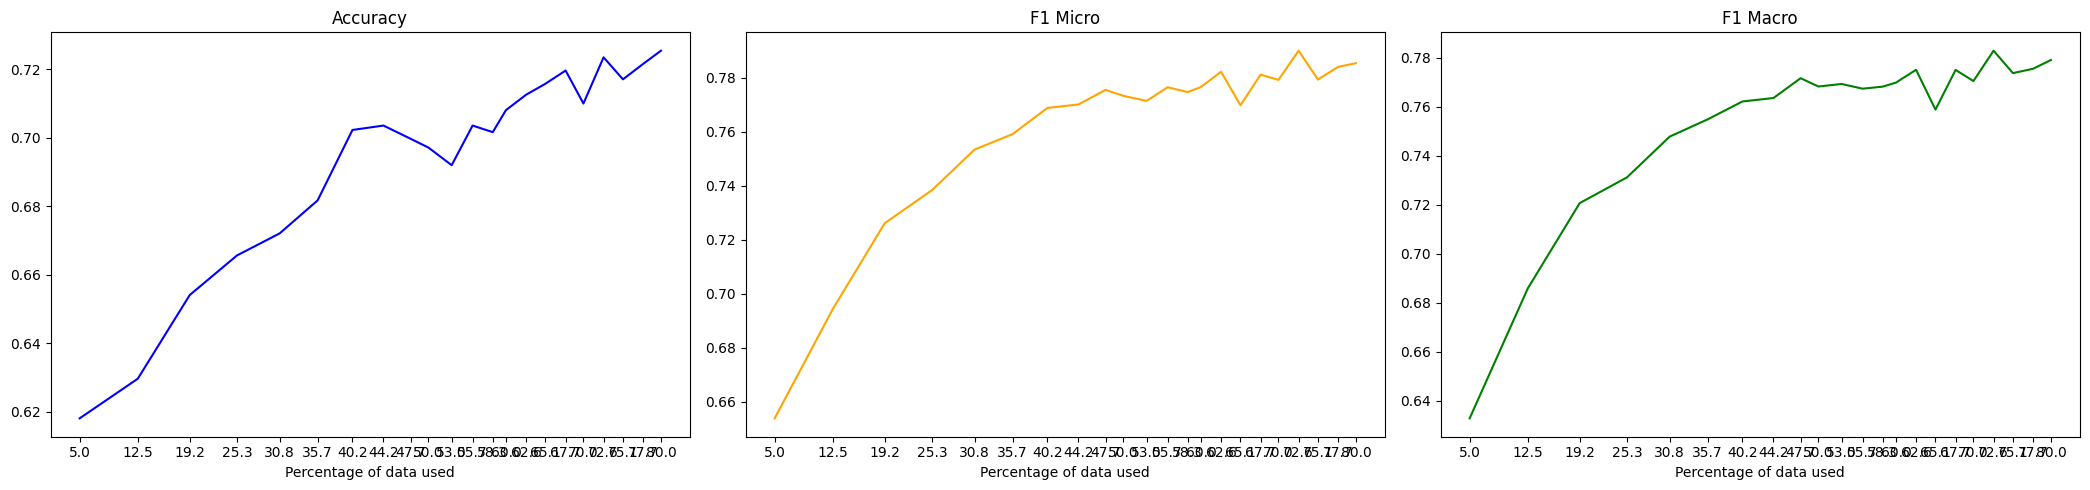

In [18]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.460827,0.440514,0.957447,0.033937,0.065550,0.044738
2,No log,0.398824,0.576849,0.872222,0.236802,0.372479,0.261927
3,No log,0.353225,0.591640,0.830054,0.349925,0.492308,0.420032
4,No log,0.330393,0.585852,0.775510,0.429864,0.553130,0.459224
5,No log,0.314286,0.593569,0.761511,0.486425,0.593649,0.525215
6,No log,0.306425,0.605145,0.788366,0.480392,0.597001,0.545943
7,No log,0.299625,0.612862,0.739634,0.578431,0.649175,0.610205
8,No log,0.297249,0.616720,0.771834,0.533183,0.630687,0.596109
9,No log,0.294833,0.624437,0.772004,0.549020,0.641692,0.603582
10,No log,0.295964,0.617363,0.774123,0.532428,0.630920,0.592582


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.79      0.84       362
                sara       0.74      0.23      0.35       237
         radikalisme       0.68      0.60      0.64       235
pencemaran_nama_baik       0.65      0.58      0.62       492

           micro avg       0.74      0.58      0.65      1326
           macro avg       0.74      0.55      0.61      1326
        weighted avg       0.74      0.58      0.63      1326
         samples avg       0.38      0.34      0.35      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.6128617363344051, F1 Micro: 0.649174777824799, F1 Macro: 0.6102054118583491
                      precision    recall  f1-score   support

          pornografi       0.89      0.79      0.84       362
                sara       0.74      0.23      0.35       237
         radikalisme       0.68      0.60      0.64       235
pencemaran_nama_baik       0.65      0.58      0.62       492

           micro avg       0.74      0.58      0.65      1326
           macro avg       0.74      0.55      0.61      1326
        weighted avg       0.74      0.58      0.63      1326
         samples avg       0.38      0.34      0.35      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.833769391477108
Samples above threshold: 583
Acquired samples: 583
Sampling duration: 20.444432497024536 seconds
New train size: 971


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.457623,0.522186,0.988571,0.130468,0.230513,0.161462
2,No log,0.339023,0.580707,0.845339,0.300905,0.443826,0.356335
3,No log,0.304600,0.611576,0.741164,0.537707,0.623252,0.612631
4,No log,0.295249,0.602572,0.699746,0.622172,0.658683,0.631950
5,No log,0.305601,0.618006,0.748950,0.537707,0.625988,0.580727
6,No log,0.317523,0.624437,0.764182,0.518100,0.617528,0.575472
7,No log,0.303215,0.617363,0.725543,0.604072,0.659259,0.637667
8,No log,0.305310,0.620579,0.713322,0.638009,0.673567,0.657750
9,0.152900,0.310775,0.624437,0.720690,0.630468,0.672566,0.653122
10,0.152900,0.313669,0.621865,0.716113,0.633484,0.672269,0.654227


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.86      0.87       362
                sara       0.61      0.41      0.49       237
         radikalisme       0.68      0.65      0.66       235
pencemaran_nama_baik       0.63      0.58      0.61       492

           micro avg       0.71      0.64      0.67      1326
           macro avg       0.70      0.62      0.66      1326
        weighted avg       0.71      0.64      0.67      1326
         samples avg       0.39      0.37      0.37      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 971: Accuracy: 0.6205787781350482, F1 Micro: 0.6735668789808916, F1 Macro: 0.6577501133118858
                      precision    recall  f1-score   support

          pornografi       0.89      0.86      0.87       362
                sara       0.61      0.41      0.49       237
         radikalisme       0.68      0.65      0.66       235
pencemaran_nama_baik       0.63      0.58      0.61       492

           micro avg       0.71      0.64      0.67      1326
           macro avg       0.70      0.62      0.66      1326
        weighted avg       0.71      0.64      0.67      1326
         samples avg       0.39      0.37      0.37      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.9440128356218338
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 18.354169607162476 seconds
New train size: 1496


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.398581,0.545981,0.972973,0.162896,0.279070,0.185873
2,No log,0.316895,0.592283,0.776786,0.459276,0.577251,0.508734
3,No log,0.302148,0.607717,0.656849,0.723228,0.688442,0.677239
4,No log,0.287887,0.627010,0.700962,0.714178,0.707508,0.690124
5,No log,0.293817,0.629582,0.747437,0.604827,0.668612,0.639493
6,0.149500,0.292686,0.639871,0.718131,0.684012,0.700657,0.690623
7,0.149500,0.302458,0.628939,0.684806,0.730769,0.707041,0.698042
8,0.149500,0.309311,0.645016,0.726446,0.662896,0.693218,0.671450
9,0.149500,0.315246,0.649518,0.719101,0.675716,0.696734,0.676587
10,0.149500,0.316333,0.636013,0.700977,0.703620,0.702296,0.686943


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.86      0.89      0.87       362
                sara       0.63      0.53      0.58       237
         radikalisme       0.66      0.61      0.63       235
pencemaran_nama_baik       0.63      0.73      0.68       492

           micro avg       0.70      0.71      0.71      1326
           macro avg       0.70      0.69      0.69      1326
        weighted avg       0.70      0.71      0.71      1326
         samples avg       0.40      0.40      0.39      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1496: Accuracy: 0.6270096463022508, F1 Micro: 0.7075084049308928, F1 Macro: 0.6901240298872042
                      precision    recall  f1-score   support

          pornografi       0.86      0.89      0.87       362
                sara       0.63      0.53      0.58       237
         radikalisme       0.66      0.61      0.63       235
pencemaran_nama_baik       0.63      0.73      0.68       492

           micro avg       0.70      0.71      0.71      1326
           macro avg       0.70      0.69      0.69      1326
        weighted avg       0.70      0.71      0.71      1326
         samples avg       0.40      0.40      0.39      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.8236494466662407
Samples above threshold: 473
Acquired samples: 473
Sampling duration: 16.460479497909546 seconds
New train size: 1969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.380157,0.574277,0.906627,0.226998,0.363088,0.246063
2,No log,0.299322,0.627653,0.667327,0.762443,0.711721,0.702477
3,No log,0.280386,0.648232,0.746736,0.647059,0.693333,0.663577
4,No log,0.289340,0.644373,0.663278,0.836350,0.739827,0.738275
5,0.168000,0.275659,0.670740,0.757877,0.689291,0.721959,0.701907
6,0.168000,0.290528,0.645016,0.720301,0.722474,0.721386,0.692810
7,0.168000,0.301247,0.652733,0.715015,0.739819,0.727205,0.714959
8,0.168000,0.299369,0.657878,0.720964,0.744344,0.732468,0.720742
9,0.062900,0.304631,0.659807,0.733538,0.722474,0.727964,0.713145
10,0.062900,0.310847,0.650804,0.711937,0.751131,0.731009,0.717428


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.88      0.89       362
                sara       0.57      0.73      0.64       237
         radikalisme       0.65      0.82      0.73       235
pencemaran_nama_baik       0.60      0.87      0.71       492

           micro avg       0.66      0.84      0.74      1326
           macro avg       0.68      0.82      0.74      1326
        weighted avg       0.68      0.84      0.75      1326
         samples avg       0.44      0.47      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1969: Accuracy: 0.6443729903536978, F1 Micro: 0.7398265510340227, F1 Macro: 0.7382749134976028
                      precision    recall  f1-score   support

          pornografi       0.89      0.88      0.89       362
                sara       0.57      0.73      0.64       237
         radikalisme       0.65      0.82      0.73       235
pencemaran_nama_baik       0.60      0.87      0.71       492

           micro avg       0.66      0.84      0.74      1326
           macro avg       0.68      0.82      0.74      1326
        weighted avg       0.68      0.84      0.75      1326
         samples avg       0.44      0.47      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.5638537347316747
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 14.971923828125 seconds
New train size: 2394


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.411474,0.553055,0.978723,0.173454,0.294683,0.194233
2,No log,0.301257,0.610932,0.806944,0.438160,0.567937,0.524658
3,No log,0.266130,0.655305,0.747733,0.684012,0.714455,0.704529
4,0.189800,0.266199,0.669453,0.724803,0.764706,0.744220,0.734935
5,0.189800,0.267721,0.676527,0.746533,0.730769,0.738567,0.729636
6,0.189800,0.293030,0.658521,0.708623,0.768477,0.737337,0.723566
7,0.079200,0.299059,0.669453,0.709437,0.788084,0.746695,0.738236
8,0.079200,0.310849,0.663666,0.714085,0.768477,0.740283,0.725550
9,0.079200,0.311322,0.657235,0.715203,0.755656,0.734873,0.723849
10,0.043100,0.318910,0.661093,0.706566,0.779035,0.741033,0.729225


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.88      0.90       362
                sara       0.56      0.63      0.59       237
         radikalisme       0.67      0.83      0.74       235
pencemaran_nama_baik       0.67      0.78      0.72       492

           micro avg       0.71      0.79      0.75      1326
           macro avg       0.70      0.78      0.74      1326
        weighted avg       0.72      0.79      0.75      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2394: Accuracy: 0.6694533762057878, F1 Micro: 0.7466952483029654, F1 Macro: 0.7382359496160397
                      precision    recall  f1-score   support

          pornografi       0.91      0.88      0.90       362
                sara       0.56      0.63      0.59       237
         radikalisme       0.67      0.83      0.74       235
pencemaran_nama_baik       0.67      0.78      0.72       492

           micro avg       0.71      0.79      0.75      1326
           macro avg       0.70      0.78      0.74      1326
        weighted avg       0.72      0.79      0.75      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.4944411754608158
Samples above threshold: 383
Acquired samples: 383
Sampling duration: 13.449349641799927 seconds
New train size: 2777


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.354686,0.566559,0.945255,0.195324,0.323750,0.226589
2,No log,0.281494,0.649518,0.679872,0.802413,0.736077,0.730271
3,0.210500,0.269177,0.660450,0.699098,0.818250,0.753996,0.750018
4,0.210500,0.260668,0.688103,0.743045,0.765460,0.754086,0.742276
5,0.210500,0.278498,0.677814,0.711625,0.835596,0.768644,0.763462
6,0.102300,0.281816,0.678457,0.722485,0.806938,0.762380,0.757023
7,0.102300,0.317238,0.667524,0.698184,0.840875,0.762915,0.759519
8,0.102300,0.303239,0.684244,0.726712,0.800151,0.761665,0.751117
9,0.054100,0.314046,0.681672,0.719707,0.815234,0.764498,0.756639
10,0.054100,0.310831,0.684244,0.723605,0.811463,0.765020,0.758454


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.91      0.90       362
                sara       0.61      0.74      0.67       237
         radikalisme       0.68      0.83      0.75       235
pencemaran_nama_baik       0.67      0.83      0.74       492

           micro avg       0.71      0.84      0.77      1326
           macro avg       0.71      0.83      0.76      1326
        weighted avg       0.72      0.84      0.77      1326
         samples avg       0.45      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2777: Accuracy: 0.6778135048231512, F1 Micro: 0.7686437738466875, F1 Macro: 0.7634624433901256
                      precision    recall  f1-score   support

          pornografi       0.89      0.91      0.90       362
                sara       0.61      0.74      0.67       237
         radikalisme       0.68      0.83      0.75       235
pencemaran_nama_baik       0.67      0.83      0.74       492

           micro avg       0.71      0.84      0.77      1326
           macro avg       0.71      0.83      0.76      1326
        weighted avg       0.72      0.84      0.77      1326
         samples avg       0.45      0.47      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.24177396297454834
Samples above threshold: 345
Acquired samples: 345
Sampling duration: 12.193474054336548 seconds
New train size: 3122


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.323585,0.575563,0.846774,0.316742,0.461032,0.377346
2,No log,0.266408,0.655305,0.736196,0.723982,0.730038,0.720711
3,0.235800,0.258122,0.673312,0.776641,0.687029,0.729092,0.722186
4,0.235800,0.263132,0.691961,0.722074,0.819005,0.767491,0.761371
5,0.235800,0.275398,0.681029,0.721485,0.820513,0.767819,0.760926
6,0.122700,0.308900,0.670096,0.686630,0.855958,0.762001,0.760190
7,0.122700,0.295462,0.688103,0.725084,0.817496,0.768522,0.762393
8,0.071800,0.306432,0.688103,0.722296,0.815988,0.766289,0.761127
9,0.071800,0.312900,0.688746,0.726536,0.811463,0.766655,0.759009
10,0.071800,0.314985,0.688103,0.724579,0.811463,0.765564,0.758026


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.89      0.90       362
                sara       0.61      0.69      0.65       237
         radikalisme       0.69      0.85      0.76       235
pencemaran_nama_baik       0.68      0.81      0.74       492

           micro avg       0.73      0.82      0.77      1326
           macro avg       0.72      0.81      0.76      1326
        weighted avg       0.73      0.82      0.77      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3122: Accuracy: 0.6881028938906752, F1 Micro: 0.7685218007798653, F1 Macro: 0.7623934222058979
                      precision    recall  f1-score   support

          pornografi       0.92      0.89      0.90       362
                sara       0.61      0.69      0.65       237
         radikalisme       0.69      0.85      0.76       235
pencemaran_nama_baik       0.68      0.81      0.74       492

           micro avg       0.73      0.82      0.77      1326
           macro avg       0.72      0.81      0.76      1326
        weighted avg       0.73      0.82      0.77      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0981287956237793
Samples above threshold: 310
Acquired samples: 310
Sampling duration: 10.923182964324951 seconds
New train size: 3432


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.305854,0.607717,0.761506,0.549020,0.638037,0.625403
2,No log,0.263644,0.655305,0.780331,0.640271,0.703397,0.693727
3,0.252300,0.247327,0.689389,0.733564,0.799397,0.765067,0.759776
4,0.252300,0.258958,0.701608,0.730201,0.820513,0.772727,0.764311
5,0.142300,0.288178,0.686817,0.704261,0.847662,0.769336,0.764777
6,0.142300,0.290117,0.688746,0.718016,0.829563,0.769769,0.765106
7,0.083100,0.298045,0.697749,0.734417,0.817496,0.773733,0.768983
8,0.083100,0.320058,0.684887,0.711367,0.840121,0.770401,0.766852
9,0.083100,0.320728,0.691318,0.721785,0.829563,0.771930,0.767817
10,0.056100,0.316635,0.688103,0.727946,0.815234,0.769121,0.763431


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.61      0.68      0.64       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.68      0.80      0.74       492

           micro avg       0.73      0.82      0.77      1326
           macro avg       0.73      0.81      0.77      1326
        weighted avg       0.74      0.82      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3432: Accuracy: 0.6977491961414791, F1 Micro: 0.7737330478229836, F1 Macro: 0.7689832337806624
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.61      0.68      0.64       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.68      0.80      0.74       492

           micro avg       0.73      0.82      0.77      1326
           macro avg       0.73      0.81      0.77      1326
        weighted avg       0.74      0.82      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.058261364698410034
Samples above threshold: 279
Acquired samples: 279
Sampling duration: 9.913101196289062 seconds
New train size: 3711


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.304269,0.610932,0.824100,0.448718,0.581055,0.515030
2,No log,0.253208,0.686174,0.789792,0.688537,0.735697,0.725431
3,0.272300,0.244975,0.707395,0.759679,0.784314,0.771800,0.759923
4,0.272300,0.256815,0.701608,0.743894,0.803922,0.772744,0.767189
5,0.158800,0.271401,0.705466,0.734639,0.820513,0.775205,0.768632
6,0.158800,0.278064,0.700965,0.743536,0.802413,0.771853,0.766297
7,0.101500,0.297332,0.701608,0.727333,0.828808,0.774762,0.769247
8,0.101500,0.312023,0.697106,0.724161,0.829563,0.773286,0.767784
9,0.068400,0.311064,0.697106,0.732574,0.824284,0.775727,0.770610
10,0.068400,0.317672,0.693248,0.725050,0.827300,0.772807,0.767272


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.91      0.91       362
                sara       0.63      0.69      0.66       237
         radikalisme       0.71      0.86      0.77       235
pencemaran_nama_baik       0.68      0.81      0.74       492

           micro avg       0.73      0.82      0.78      1326
           macro avg       0.73      0.82      0.77      1326
        weighted avg       0.74      0.82      0.78      1326
         samples avg       0.46      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3711: Accuracy: 0.6971061093247588, F1 Micro: 0.7757274662881475, F1 Macro: 0.7706104711980583
                      precision    recall  f1-score   support

          pornografi       0.90      0.91      0.91       362
                sara       0.63      0.69      0.66       237
         radikalisme       0.71      0.86      0.77       235
pencemaran_nama_baik       0.68      0.81      0.74       492

           micro avg       0.73      0.82      0.78      1326
           macro avg       0.73      0.82      0.77      1326
        weighted avg       0.74      0.82      0.78      1326
         samples avg       0.46      0.47      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.024173581600189214
Samples above threshold: 251
Acquired samples: 175
Sampling duration: 9.052999019622803 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.310015,0.603215,0.828076,0.395928,0.535714,0.494897
2,No log,0.248881,0.697749,0.792453,0.696833,0.741573,0.729545
3,0.279700,0.243890,0.694534,0.754231,0.773002,0.763501,0.757133
4,0.279700,0.242220,0.711254,0.748939,0.798643,0.772993,0.765505
5,0.169800,0.270134,0.703537,0.725246,0.834087,0.775868,0.770264
6,0.169800,0.290913,0.690032,0.723077,0.815234,0.766395,0.758790
7,0.109400,0.294389,0.704180,0.744089,0.806938,0.774240,0.768707
8,0.109400,0.321028,0.690032,0.712364,0.838612,0.770350,0.766511
9,0.073500,0.323351,0.682958,0.712532,0.831825,0.767571,0.764115
10,0.073500,0.316287,0.696463,0.732835,0.812971,0.770826,0.765822


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.58      0.70      0.64       237
         radikalisme       0.71      0.89      0.79       235
pencemaran_nama_baik       0.69      0.82      0.75       492

           micro avg       0.73      0.83      0.78      1326
           macro avg       0.72      0.83      0.77      1326
        weighted avg       0.73      0.83      0.78      1326
         samples avg       0.45      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.7035369774919614, F1 Micro: 0.7758681164503682, F1 Macro: 0.7702635689963047
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.58      0.70      0.64       237
         radikalisme       0.71      0.89      0.79       235
pencemaran_nama_baik       0.69      0.82      0.75       492

           micro avg       0.73      0.83      0.78      1326
           macro avg       0.72      0.83      0.77      1326
        weighted avg       0.73      0.83      0.78      1326
         samples avg       0.45      0.47      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.04828953742980957
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 8.364179611206055 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.281460,0.652090,0.784276,0.616893,0.690587,0.691970
2,0.290100,0.248439,0.695177,0.755622,0.760181,0.757895,0.750201
3,0.290100,0.237754,0.706752,0.745833,0.809955,0.776573,0.769675
4,0.180100,0.239002,0.708682,0.773556,0.767722,0.770628,0.756215
5,0.180100,0.260386,0.696463,0.731938,0.817496,0.772355,0.768453
6,0.120000,0.276196,0.707395,0.730897,0.829563,0.777111,0.773000
7,0.120000,0.292459,0.697749,0.730615,0.824284,0.774628,0.771790
8,0.080100,0.301950,0.692605,0.722805,0.831825,0.773492,0.769149
9,0.080100,0.299890,0.705466,0.746186,0.811463,0.777457,0.772420
10,0.063500,0.304362,0.708682,0.749300,0.806938,0.777052,0.769757


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.63      0.68      0.65       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.69      0.79      0.74       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.7054662379421222, F1 Micro: 0.777456647398844, F1 Macro: 0.7724196153867551
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.63      0.68      0.65       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.69      0.79      0.74       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.01313660144805908
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 7.563161611557007 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.280129,0.645659,0.724474,0.727753,0.726110,0.709937
2,0.297800,0.248436,0.684244,0.793411,0.671946,0.727644,0.719373
3,0.297800,0.235236,0.708039,0.748065,0.801659,0.773935,0.769768
4,0.187100,0.239891,0.722830,0.784223,0.764706,0.774341,0.763832
5,0.187100,0.266946,0.702251,0.736159,0.812217,0.772320,0.767855
6,0.131600,0.278042,0.705466,0.739792,0.806184,0.771563,0.768075
7,0.131600,0.289900,0.715113,0.748951,0.807692,0.777213,0.770464
8,0.088000,0.319409,0.701608,0.722258,0.839367,0.776421,0.771673
9,0.088000,0.311258,0.709968,0.741225,0.812217,0.775099,0.769644
10,0.065200,0.314206,0.710611,0.743113,0.813725,0.776818,0.771719


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.92      0.92       362
                sara       0.62      0.66      0.64       237
         radikalisme       0.75      0.81      0.78       235
pencemaran_nama_baik       0.69      0.80      0.74       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.715112540192926, F1 Micro: 0.7772133526850509, F1 Macro: 0.7704641293942245
                      precision    recall  f1-score   support

          pornografi       0.93      0.92      0.92       362
                sara       0.62      0.66      0.64       237
         radikalisme       0.75      0.81      0.78       235
pencemaran_nama_baik       0.69      0.80      0.74       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.013950610160827633
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 6.7984299659729 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.272168,0.666238,0.757676,0.688537,0.721454,0.721161
2,0.303000,0.242680,0.704180,0.762816,0.751885,0.757311,0.756210
3,0.303000,0.240034,0.698392,0.764394,0.760935,0.762661,0.748587
4,0.201500,0.245899,0.708039,0.764925,0.773002,0.768942,0.761371
5,0.201500,0.264047,0.709325,0.733113,0.834842,0.780677,0.776252
6,0.138300,0.274976,0.709968,0.750708,0.799397,0.774288,0.766444
7,0.138300,0.292892,0.707395,0.746827,0.798643,0.771866,0.765986
8,0.098400,0.303168,0.704823,0.744444,0.808446,0.775127,0.770499
9,0.070800,0.302877,0.713183,0.758941,0.800151,0.779001,0.772673
10,0.070800,0.311789,0.709968,0.748599,0.806184,0.776325,0.768851


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.58      0.75      0.65       237
         radikalisme       0.71      0.86      0.78       235
pencemaran_nama_baik       0.71      0.82      0.76       492

           micro avg       0.73      0.83      0.78      1326
           macro avg       0.73      0.83      0.78      1326
        weighted avg       0.75      0.83      0.79      1326
         samples avg       0.45      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.7093247588424437, F1 Micro: 0.7806770098730607, F1 Macro: 0.776252433539169
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.58      0.75      0.65       237
         radikalisme       0.71      0.86      0.78       235
pencemaran_nama_baik       0.71      0.82      0.76       492

           micro avg       0.73      0.83      0.78      1326
           macro avg       0.73      0.83      0.78      1326
        weighted avg       0.75      0.83      0.79      1326
         samples avg       0.45      0.47      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.024097865819931025
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 6.246138095855713 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.270330,0.673955,0.769294,0.706637,0.736635,0.724091
2,0.311900,0.239017,0.707395,0.786885,0.723982,0.754124,0.743669
3,0.311900,0.248150,0.698392,0.735967,0.800905,0.767064,0.757677
4,0.203800,0.245634,0.710611,0.778034,0.763952,0.770928,0.760160
5,0.203800,0.261598,0.711897,0.754676,0.791101,0.772459,0.765249
6,0.147300,0.286696,0.703537,0.730053,0.828054,0.775972,0.772787
7,0.103000,0.287806,0.716399,0.762079,0.785068,0.773403,0.766964
8,0.103000,0.293510,0.710611,0.756237,0.800151,0.777574,0.771406
9,0.076500,0.300654,0.716399,0.766862,0.788839,0.777695,0.769448
10,0.076500,0.311232,0.712540,0.752635,0.807692,0.779192,0.772286


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.92       362
                sara       0.63      0.67      0.65       237
         radikalisme       0.73      0.83      0.78       235
pencemaran_nama_baik       0.71      0.78      0.74       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.712540192926045, F1 Micro: 0.7791924336122227, F1 Macro: 0.7722862991873517
                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.92       362
                sara       0.63      0.67      0.65       237
         radikalisme       0.73      0.83      0.78       235
pencemaran_nama_baik       0.71      0.78      0.74       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.009209966659545904
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 5.707566499710083 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.267625,0.646302,0.730530,0.707391,0.718774,0.716034
2,0.302700,0.246526,0.681672,0.738304,0.761689,0.749814,0.748342
3,0.302700,0.232405,0.716399,0.759913,0.794872,0.777000,0.771544
4,0.204300,0.241845,0.707395,0.755957,0.789593,0.772409,0.766413
5,0.148400,0.259386,0.716399,0.763518,0.798643,0.780686,0.771919
6,0.148400,0.290076,0.696463,0.719608,0.830317,0.771008,0.765984
7,0.102000,0.284972,0.716399,0.767062,0.779789,0.773373,0.759352
8,0.102000,0.311881,0.715113,0.744990,0.812971,0.777497,0.772628
9,0.077800,0.309808,0.717685,0.757706,0.797134,0.776920,0.766374
10,0.063800,0.312494,0.715756,0.753008,0.802413,0.776926,0.768340


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.65      0.62      0.63       237
         radikalisme       0.74      0.86      0.79       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.7163987138263666, F1 Micro: 0.7806855879100627, F1 Macro: 0.7719194805720672
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.65      0.62      0.63       237
         radikalisme       0.74      0.86      0.79       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.020325028896331795
Samples above threshold: 136
Acquired samples: 200
Sampling duration: 4.979373455047607 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.257308,0.674598,0.775281,0.676471,0.722513,0.719533
2,0.305100,0.234987,0.699035,0.775281,0.728507,0.751166,0.737322
3,0.305100,0.228113,0.713826,0.768546,0.781297,0.774869,0.767863
4,0.207000,0.245493,0.710611,0.761388,0.794118,0.777409,0.768704
5,0.148500,0.256652,0.722830,0.752592,0.821267,0.785431,0.780294
6,0.148500,0.279395,0.720900,0.755088,0.811463,0.782261,0.773697
7,0.107500,0.297761,0.699035,0.733199,0.822775,0.775409,0.768300
8,0.081000,0.299256,0.713183,0.758179,0.803922,0.780381,0.770419
9,0.081000,0.307033,0.718328,0.757917,0.812217,0.784128,0.775999
10,0.063200,0.306226,0.716399,0.761461,0.801659,0.781043,0.771896


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.60      0.76      0.67       237
         radikalisme       0.70      0.88      0.78       235
pencemaran_nama_baik       0.76      0.76      0.76       492

           micro avg       0.75      0.82      0.79      1326
           macro avg       0.74      0.83      0.78      1326
        weighted avg       0.76      0.82      0.79      1326
         samples avg       0.45      0.46      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.7228295819935692, F1 Micro: 0.7854309412188965, F1 Macro: 0.7802937237399016
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.60      0.76      0.67       237
         radikalisme       0.70      0.88      0.78       235
pencemaran_nama_baik       0.76      0.76      0.76       492

           micro avg       0.75      0.82      0.79      1326
           macro avg       0.74      0.83      0.78      1326
        weighted avg       0.76      0.82      0.79      1326
         samples avg       0.45      0.46      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.0118179202079773
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 4.2845778465271 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.252621,0.690675,0.763382,0.742081,0.752581,0.745605
2,0.309200,0.235480,0.702894,0.744219,0.800905,0.771522,0.763575
3,0.309200,0.233279,0.702894,0.762362,0.779035,0.770608,0.762285
4,0.210800,0.248906,0.709968,0.750529,0.803167,0.775956,0.769764
5,0.155400,0.254649,0.725402,0.792056,0.766968,0.779310,0.769683
6,0.155400,0.274322,0.719614,0.752991,0.806938,0.779032,0.769992
7,0.118400,0.291546,0.711897,0.747928,0.816742,0.780822,0.774879
8,0.087200,0.304308,0.715756,0.760319,0.791855,0.775767,0.768105
9,0.087200,0.309328,0.711254,0.751233,0.803922,0.776685,0.769966
10,0.071000,0.313174,0.715113,0.758941,0.800151,0.779001,0.771483


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.62      0.69      0.65       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.70      0.80      0.75       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.75      0.81      0.77      1326
        weighted avg       0.75      0.82      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.7118971061093248, F1 Micro: 0.7808219178082192, F1 Macro: 0.7748786061368818
                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.62      0.69      0.65       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.70      0.80      0.75       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.75      0.81      0.77      1326
        weighted avg       0.75      0.82      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.004847490787506104
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 3.732814073562622 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.251869,0.681029,0.783830,0.694570,0.736505,0.715402
2,0.308300,0.226508,0.710611,0.799832,0.717195,0.756262,0.740548
3,0.205300,0.224228,0.727331,0.781321,0.776018,0.778661,0.774360
4,0.205300,0.234813,0.720900,0.778875,0.773002,0.775927,0.767024
5,0.153900,0.258131,0.713826,0.749141,0.822021,0.783891,0.779365
6,0.115300,0.283269,0.709968,0.741695,0.825038,0.781150,0.775748
7,0.115300,0.286702,0.721543,0.764061,0.788839,0.776252,0.767954
8,0.086600,0.296074,0.718328,0.756028,0.803922,0.779240,0.772723
9,0.069900,0.301560,0.721543,0.772021,0.786576,0.779230,0.772294
10,0.069900,0.310143,0.720900,0.760000,0.802413,0.780631,0.773355


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.62      0.69      0.65       237
         radikalisme       0.74      0.88      0.80       235
pencemaran_nama_baik       0.70      0.79      0.75       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.75      0.82      0.78      1326
        weighted avg       0.75      0.82      0.79      1326
         samples avg       0.46      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.7138263665594855, F1 Micro: 0.7838906868033082, F1 Macro: 0.7793646092836614
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.62      0.69      0.65       237
         radikalisme       0.74      0.88      0.80       235
pencemaran_nama_baik       0.70      0.79      0.75       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.75      0.82      0.78      1326
        weighted avg       0.75      0.82      0.79      1326
         samples avg       0.46      0.47      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.005424356460571289
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 2.9650485515594482 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.244983,0.700322,0.812386,0.672700,0.735974,0.724830
2,0.303500,0.231560,0.706752,0.783026,0.737557,0.759612,0.746358
3,0.210800,0.235307,0.714469,0.756719,0.806938,0.781022,0.771245
4,0.210800,0.234255,0.720900,0.784134,0.775264,0.779674,0.767862
5,0.156500,0.261429,0.708682,0.762787,0.776018,0.769346,0.757339
6,0.118300,0.269974,0.719614,0.764490,0.785822,0.775009,0.763909
7,0.118300,0.285292,0.719614,0.760838,0.794118,0.777122,0.766922
8,0.092000,0.295406,0.718328,0.759740,0.794118,0.776549,0.767520
9,0.071500,0.306200,0.713826,0.761075,0.790347,0.775435,0.766464
10,0.059900,0.312182,0.714469,0.758496,0.791101,0.774456,0.765974


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.66      0.62      0.64       237
         radikalisme       0.74      0.82      0.78       235
pencemaran_nama_baik       0.70      0.82      0.76       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.7144694533762058, F1 Micro: 0.781021897810219, F1 Macro: 0.7712454232148067
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.66      0.62      0.64       237
         radikalisme       0.74      0.82      0.78       235
pencemaran_nama_baik       0.70      0.82      0.76       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.015227949619293205
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 2.2994015216827393 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.244591,0.701608,0.792485,0.699849,0.743292,0.731316
2,0.311700,0.234527,0.704823,0.814183,0.684012,0.743443,0.735705
3,0.211800,0.224326,0.717042,0.778714,0.766968,0.772796,0.764106
4,0.211800,0.233515,0.718328,0.808388,0.741327,0.773407,0.761492
5,0.166500,0.245601,0.718971,0.772997,0.785822,0.779357,0.772814
6,0.122900,0.260677,0.715756,0.768374,0.780543,0.774411,0.765378
7,0.093800,0.278547,0.718328,0.758719,0.803922,0.780666,0.772456
8,0.093800,0.296312,0.714469,0.749480,0.814480,0.780629,0.774399
9,0.074500,0.293371,0.718971,0.770649,0.788084,0.779269,0.771753
10,0.062700,0.297589,0.717042,0.766253,0.791101,0.778479,0.771917


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.93      0.92       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.75      0.81      0.78       235
pencemaran_nama_baik       0.71      0.79      0.75       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.7183279742765273, F1 Micro: 0.7806664225558404, F1 Macro: 0.7724561114636295
                      precision    recall  f1-score   support

          pornografi       0.91      0.93      0.92       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.75      0.81      0.78       235
pencemaran_nama_baik       0.71      0.79      0.75       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.0019749879837036148
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 1.632524013519287 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.243167,0.699035,0.749630,0.763198,0.756353,0.749630
2,0.304300,0.227903,0.717042,0.778626,0.769231,0.773900,0.765630
3,0.204300,0.227177,0.717042,0.805099,0.738311,0.770260,0.758841
4,0.161300,0.254450,0.707395,0.727745,0.844646,0.781850,0.780515
5,0.161300,0.253327,0.711897,0.745245,0.827300,0.784132,0.778067
6,0.120400,0.262725,0.721543,0.781083,0.772247,0.776640,0.766739
7,0.089600,0.286299,0.717685,0.765306,0.791855,0.778354,0.768850
8,0.073600,0.291859,0.722830,0.776208,0.787330,0.781730,0.775841
9,0.073600,0.302769,0.723473,0.769841,0.804676,0.786873,0.780021
10,0.059200,0.302172,0.723473,0.775811,0.793363,0.784489,0.776962


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.93      0.92       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.76      0.84      0.80       235
pencemaran_nama_baik       0.72      0.77      0.75       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7234726688102894, F1 Micro: 0.7868731563421829, F1 Macro: 0.7800211301351094
                      precision    recall  f1-score   support

          pornografi       0.91      0.93      0.92       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.76      0.84      0.80       235
pencemaran_nama_baik       0.72      0.77      0.75       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.001341700553894043
Samples above threshold: 19
Acquired samples: 177
Sampling duration: 1.0065374374389648 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.271169,0.664952,0.678099,0.849925,0.754351,0.754286
2,0.297400,0.223192,0.720900,0.780195,0.784314,0.782249,0.773903
3,0.201300,0.220615,0.720900,0.818723,0.725490,0.769292,0.760368
4,0.159000,0.231372,0.724116,0.775165,0.795626,0.785262,0.776548
5,0.159000,0.254296,0.713826,0.747426,0.821267,0.782609,0.779911
6,0.123600,0.258762,0.718328,0.785933,0.775264,0.780562,0.773936
7,0.092300,0.279570,0.718971,0.770300,0.794118,0.782027,0.775074
8,0.072100,0.287422,0.724759,0.785281,0.780543,0.782905,0.777079
9,0.059600,0.305485,0.720257,0.767677,0.802413,0.784661,0.777611
10,0.059600,0.306281,0.720257,0.769455,0.797888,0.783414,0.776545


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.76      0.76      0.76       492

           micro avg       0.78      0.80      0.79      1326
           macro avg       0.76      0.79      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.7241157556270097, F1 Micro: 0.7852623743952364, F1 Macro: 0.7765481009189894
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.76      0.76      0.76       492

           micro avg       0.78      0.80      0.79      1326
           macro avg       0.76      0.79      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.45      0.45      0.44      1326

Total sampling time: 181.34 seconds
Total runtime: 11772.040750265121 seconds


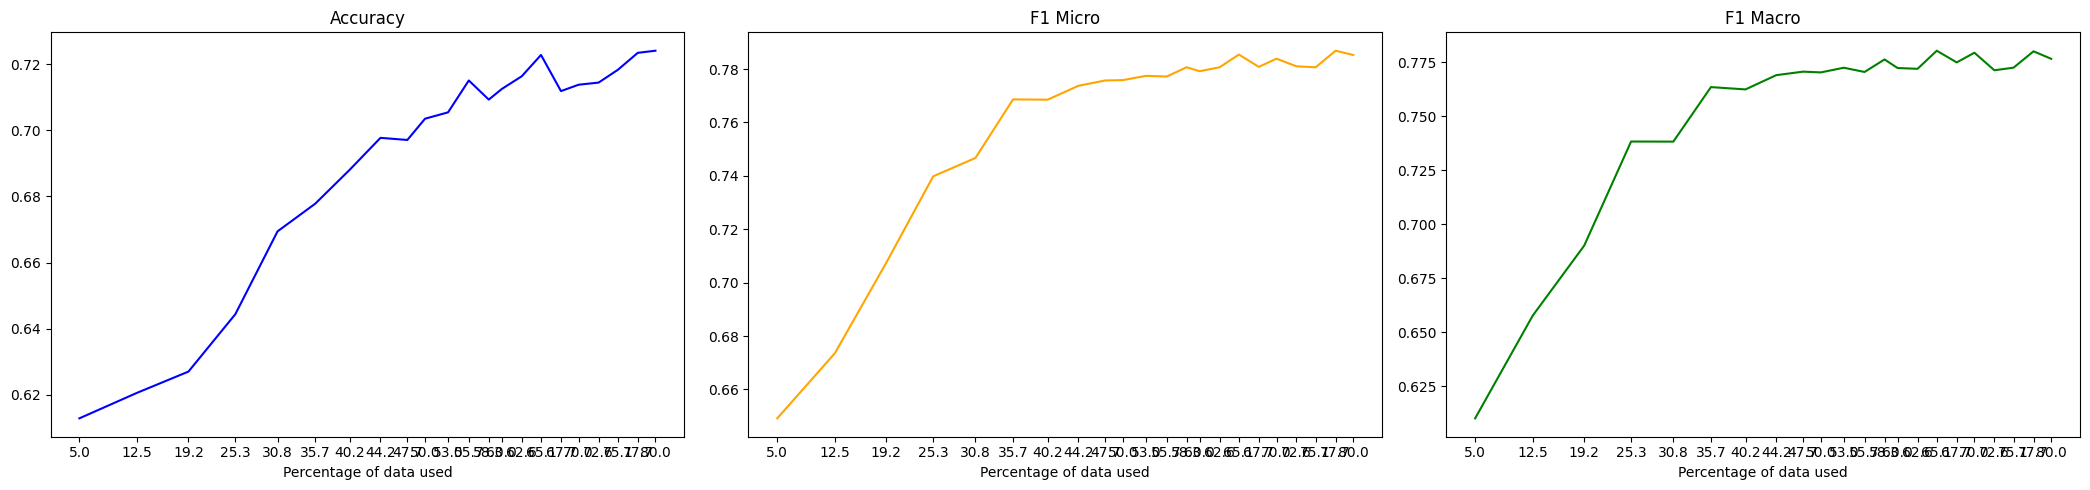

In [19]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.466312,0.447588,1.000000,0.012821,0.025316,0.022427
2,No log,0.392322,0.554984,0.920290,0.191554,0.317104,0.211713
3,No log,0.349551,0.584566,0.834646,0.319759,0.462377,0.381456
4,No log,0.331326,0.586495,0.799035,0.374811,0.510267,0.438305
5,No log,0.317812,0.590997,0.812303,0.388386,0.525510,0.465296
6,No log,0.312626,0.603859,0.802213,0.437406,0.566130,0.506563
7,No log,0.301693,0.610289,0.758030,0.533937,0.626549,0.600378
8,No log,0.300017,0.610932,0.759957,0.532428,0.626164,0.598342
9,No log,0.301048,0.610289,0.765419,0.524133,0.622202,0.587982
10,No log,0.300751,0.610289,0.768632,0.521116,0.621124,0.587391


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.81      0.86       362
                sara       0.64      0.25      0.36       237
         radikalisme       0.68      0.66      0.67       235
pencemaran_nama_baik       0.69      0.41      0.51       492

           micro avg       0.76      0.53      0.63      1326
           macro avg       0.73      0.53      0.60      1326
        weighted avg       0.74      0.53      0.61      1326
         samples avg       0.35      0.31      0.32      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.6102893890675242, F1 Micro: 0.6265486725663717, F1 Macro: 0.6003779383425171
                      precision    recall  f1-score   support

          pornografi       0.91      0.81      0.86       362
                sara       0.64      0.25      0.36       237
         radikalisme       0.68      0.66      0.67       235
pencemaran_nama_baik       0.69      0.41      0.51       492

           micro avg       0.76      0.53      0.63      1326
           macro avg       0.73      0.53      0.60      1326
        weighted avg       0.74      0.53      0.61      1326
         samples avg       0.35      0.31      0.32      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.9001256771385672
Samples above threshold: 583
Acquired samples: 583
Sampling duration: 20.279946088790894 seconds
New train size: 971


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.431681,0.481672,0.990826,0.081448,0.150523,0.115085
2,No log,0.360434,0.576206,0.873362,0.301659,0.448430,0.373639
3,No log,0.322015,0.592283,0.783967,0.435143,0.559651,0.490697
4,No log,0.301275,0.625723,0.730245,0.606335,0.662546,0.640351
5,No log,0.312008,0.618006,0.749741,0.546757,0.632359,0.594849
6,No log,0.299530,0.627010,0.722128,0.644796,0.681275,0.656455
7,No log,0.305954,0.636656,0.753976,0.607843,0.673069,0.650883
8,No log,0.313474,0.630225,0.734089,0.634992,0.680954,0.654190
9,0.139600,0.313501,0.635370,0.729915,0.644042,0.684295,0.668040
10,0.139600,0.316310,0.636656,0.735602,0.635747,0.682039,0.660932


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.88      0.84      0.86       362
                sara       0.60      0.42      0.49       237
         radikalisme       0.70      0.67      0.69       235
pencemaran_nama_baik       0.67      0.60      0.63       492

           micro avg       0.73      0.64      0.68      1326
           macro avg       0.71      0.63      0.67      1326
        weighted avg       0.72      0.64      0.68      1326
         samples avg       0.38      0.37      0.37      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 971: Accuracy: 0.6353697749196141, F1 Micro: 0.6842948717948718, F1 Macro: 0.6680398341180707
                      precision    recall  f1-score   support

          pornografi       0.88      0.84      0.86       362
                sara       0.60      0.42      0.49       237
         radikalisme       0.70      0.67      0.69       235
pencemaran_nama_baik       0.67      0.60      0.63       492

           micro avg       0.73      0.64      0.68      1326
           macro avg       0.71      0.63      0.67      1326
        weighted avg       0.72      0.64      0.68      1326
         samples avg       0.38      0.37      0.37      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.9604834452271462
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 18.34048342704773 seconds
New train size: 1496


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.380186,0.561415,0.900322,0.211161,0.342089,0.240456
2,No log,0.316414,0.594212,0.772843,0.459276,0.576159,0.508527
3,No log,0.290471,0.613505,0.718943,0.615385,0.663145,0.619180
4,No log,0.289003,0.621222,0.713932,0.653092,0.682158,0.648049
5,No log,0.297766,0.624437,0.733151,0.607089,0.664191,0.630518
6,0.151500,0.305933,0.628939,0.717320,0.662142,0.688627,0.664446
7,0.151500,0.316594,0.637299,0.725166,0.660633,0.691397,0.670878
8,0.151500,0.316213,0.638585,0.715066,0.690799,0.702723,0.687419
9,0.151500,0.322011,0.627010,0.694424,0.704374,0.699364,0.684138
10,0.151500,0.321270,0.632797,0.715981,0.682504,0.698842,0.680184


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.87      0.88      0.87       362
                sara       0.61      0.46      0.52       237
         radikalisme       0.68      0.73      0.70       235
pencemaran_nama_baik       0.66      0.65      0.65       492

           micro avg       0.72      0.69      0.70      1326
           macro avg       0.70      0.68      0.69      1326
        weighted avg       0.71      0.69      0.70      1326
         samples avg       0.41      0.40      0.40      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1496: Accuracy: 0.6385852090032155, F1 Micro: 0.702723436900652, F1 Macro: 0.6874194850035489
                      precision    recall  f1-score   support

          pornografi       0.87      0.88      0.87       362
                sara       0.61      0.46      0.52       237
         radikalisme       0.68      0.73      0.70       235
pencemaran_nama_baik       0.66      0.65      0.65       492

           micro avg       0.72      0.69      0.70      1326
           macro avg       0.70      0.68      0.69      1326
        weighted avg       0.71      0.69      0.70      1326
         samples avg       0.41      0.40      0.40      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.9160847365856173
Samples above threshold: 473
Acquired samples: 473
Sampling duration: 16.579848051071167 seconds
New train size: 1969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.386353,0.567203,0.931034,0.203620,0.334158,0.229097
2,No log,0.293481,0.627010,0.698925,0.686275,0.692542,0.677264
3,No log,0.281488,0.636656,0.772115,0.605581,0.678783,0.656544
4,No log,0.299001,0.630225,0.763209,0.588235,0.664395,0.604828
5,0.168900,0.305542,0.627010,0.727586,0.636501,0.679002,0.645273
6,0.168900,0.287536,0.648875,0.744454,0.683258,0.712544,0.699220
7,0.168900,0.295754,0.646945,0.740260,0.687783,0.713057,0.699573
8,0.168900,0.316333,0.636013,0.705248,0.739819,0.722120,0.712118
9,0.062300,0.309833,0.647588,0.729214,0.720965,0.725066,0.715032
10,0.062300,0.313971,0.641801,0.717009,0.737557,0.727138,0.719061


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.85      0.90      0.88       362
                sara       0.65      0.58      0.61       237
         radikalisme       0.67      0.76      0.71       235
pencemaran_nama_baik       0.66      0.68      0.67       492

           micro avg       0.72      0.74      0.73      1326
           macro avg       0.71      0.73      0.72      1326
        weighted avg       0.72      0.74      0.73      1326
         samples avg       0.43      0.42      0.41      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1969: Accuracy: 0.6418006430868167, F1 Micro: 0.7271375464684016, F1 Macro: 0.7190611762789676
                      precision    recall  f1-score   support

          pornografi       0.85      0.90      0.88       362
                sara       0.65      0.58      0.61       237
         radikalisme       0.67      0.76      0.71       235
pencemaran_nama_baik       0.66      0.68      0.67       492

           micro avg       0.72      0.74      0.73      1326
           macro avg       0.71      0.73      0.72      1326
        weighted avg       0.72      0.74      0.73      1326
         samples avg       0.43      0.42      0.41      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.8117901474237443
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 14.891550064086914 seconds
New train size: 2394


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.359753,0.565273,0.928328,0.205128,0.336010,0.234836
2,No log,0.291877,0.630225,0.733673,0.652338,0.690619,0.665151
3,No log,0.271011,0.647588,0.772560,0.632730,0.695688,0.685945
4,0.189600,0.266707,0.657878,0.733131,0.729261,0.731191,0.721194
5,0.189600,0.281018,0.655305,0.721937,0.742081,0.731871,0.723610
6,0.189600,0.282829,0.667524,0.723164,0.772247,0.746900,0.743106
7,0.081500,0.300542,0.665595,0.718508,0.769985,0.743356,0.733588
8,0.081500,0.308406,0.665595,0.727601,0.759427,0.743173,0.732138
9,0.081500,0.309394,0.668167,0.731921,0.755656,0.743599,0.735495
10,0.045500,0.313657,0.669453,0.724576,0.773756,0.748359,0.740743


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.86      0.91      0.88       362
                sara       0.63      0.60      0.62       237
         radikalisme       0.71      0.82      0.76       235
pencemaran_nama_baik       0.67      0.74      0.71       492

           micro avg       0.72      0.77      0.75      1326
           macro avg       0.72      0.77      0.74      1326
        weighted avg       0.72      0.77      0.75      1326
         samples avg       0.44      0.45      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2394: Accuracy: 0.6694533762057878, F1 Micro: 0.7483588621444202, F1 Macro: 0.740742975517812
                      precision    recall  f1-score   support

          pornografi       0.86      0.91      0.88       362
                sara       0.63      0.60      0.62       237
         radikalisme       0.71      0.82      0.76       235
pencemaran_nama_baik       0.67      0.74      0.71       492

           micro avg       0.72      0.77      0.75      1326
           macro avg       0.72      0.77      0.74      1326
        weighted avg       0.72      0.77      0.75      1326
         samples avg       0.44      0.45      0.43      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.5142729371786122
Samples above threshold: 383
Acquired samples: 383
Sampling duration: 13.498533725738525 seconds
New train size: 2777


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.338668,0.563987,0.763966,0.412519,0.535749,0.420530
2,No log,0.279870,0.647588,0.791455,0.586727,0.673885,0.661075
3,0.218500,0.262697,0.654662,0.775201,0.655354,0.710257,0.695617
4,0.218500,0.277204,0.665595,0.708505,0.779035,0.742098,0.734619
5,0.218500,0.290331,0.666238,0.700195,0.813725,0.752703,0.750175
6,0.103200,0.293706,0.668167,0.711423,0.803167,0.754516,0.751448
7,0.103200,0.312749,0.664952,0.711656,0.787330,0.747583,0.740654
8,0.103200,0.311848,0.673955,0.718367,0.796380,0.755365,0.750936
9,0.055900,0.327543,0.668167,0.711989,0.801659,0.754168,0.750980
10,0.055900,0.325884,0.668167,0.715364,0.786576,0.749282,0.742767


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.89      0.89       362
                sara       0.62      0.65      0.63       237
         radikalisme       0.70      0.84      0.76       235
pencemaran_nama_baik       0.66      0.77      0.71       492

           micro avg       0.72      0.80      0.76      1326
           macro avg       0.72      0.79      0.75      1326
        weighted avg       0.72      0.80      0.76      1326
         samples avg       0.45      0.46      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2777: Accuracy: 0.6739549839228296, F1 Micro: 0.7553648068669526, F1 Macro: 0.7509364479472371
                      precision    recall  f1-score   support

          pornografi       0.89      0.89      0.89       362
                sara       0.62      0.65      0.63       237
         radikalisme       0.70      0.84      0.76       235
pencemaran_nama_baik       0.66      0.77      0.71       492

           micro avg       0.72      0.80      0.76      1326
           macro avg       0.72      0.79      0.75      1326
        weighted avg       0.72      0.80      0.76      1326
         samples avg       0.45      0.46      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.16723424196243286
Samples above threshold: 345
Acquired samples: 345
Sampling duration: 12.209644556045532 seconds
New train size: 3122


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.331992,0.569132,0.860000,0.291855,0.435811,0.340852
2,No log,0.275400,0.637942,0.822695,0.524887,0.640884,0.605180
3,0.238800,0.257983,0.672026,0.740941,0.724736,0.732749,0.719736
4,0.238800,0.287859,0.672026,0.688738,0.839367,0.756628,0.751689
5,0.238800,0.278985,0.677814,0.725750,0.784314,0.753896,0.742099
6,0.126500,0.308369,0.681029,0.711564,0.816742,0.760534,0.754254
7,0.126500,0.305893,0.691318,0.727582,0.807692,0.765547,0.760423
8,0.073500,0.313344,0.689389,0.723232,0.809955,0.764141,0.758886
9,0.073500,0.323617,0.691961,0.721629,0.815234,0.765581,0.759709
10,0.073500,0.321819,0.693891,0.730506,0.805430,0.766141,0.759405


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.91      0.90       362
                sara       0.63      0.66      0.64       237
         radikalisme       0.70      0.84      0.76       235
pencemaran_nama_baik       0.69      0.78      0.73       492

           micro avg       0.73      0.81      0.77      1326
           macro avg       0.73      0.80      0.76      1326
        weighted avg       0.73      0.81      0.77      1326
         samples avg       0.45      0.46      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3122: Accuracy: 0.6938906752411576, F1 Micro: 0.7661406025824964, F1 Macro: 0.7594049117900403
                      precision    recall  f1-score   support

          pornografi       0.89      0.91      0.90       362
                sara       0.63      0.66      0.64       237
         radikalisme       0.70      0.84      0.76       235
pencemaran_nama_baik       0.69      0.78      0.73       492

           micro avg       0.73      0.81      0.77      1326
           macro avg       0.73      0.80      0.76      1326
        weighted avg       0.73      0.81      0.77      1326
         samples avg       0.45      0.46      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.06955721974372864
Samples above threshold: 310
Acquired samples: 310
Sampling duration: 11.038155317306519 seconds
New train size: 3432


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.324663,0.577492,0.845703,0.326546,0.471164,0.431756
2,No log,0.267965,0.655305,0.713483,0.766214,0.738909,0.734938
3,0.256600,0.247440,0.679743,0.746291,0.758673,0.752431,0.743903
4,0.256600,0.255130,0.687460,0.753040,0.747360,0.750189,0.737269
5,0.145500,0.294900,0.681672,0.698885,0.850679,0.767347,0.765877
6,0.145500,0.289422,0.695820,0.726783,0.814480,0.768137,0.762689
7,0.086500,0.298712,0.691961,0.736434,0.788084,0.761384,0.754992
8,0.086500,0.315075,0.690032,0.730399,0.800905,0.764029,0.756093
9,0.086500,0.326489,0.690032,0.724764,0.812217,0.766003,0.760297
10,0.057000,0.326358,0.695820,0.731790,0.810709,0.769231,0.764100


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.91       362
                sara       0.61      0.68      0.65       237
         radikalisme       0.70      0.85      0.77       235
pencemaran_nama_baik       0.69      0.79      0.73       492

           micro avg       0.73      0.81      0.77      1326
           macro avg       0.73      0.81      0.76      1326
        weighted avg       0.74      0.81      0.77      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3432: Accuracy: 0.6958199356913183, F1 Micro: 0.7692307692307692, F1 Macro: 0.7641004165047378
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.91       362
                sara       0.61      0.68      0.65       237
         radikalisme       0.70      0.85      0.77       235
pencemaran_nama_baik       0.69      0.79      0.73       492

           micro avg       0.73      0.81      0.77      1326
           macro avg       0.73      0.81      0.76      1326
        weighted avg       0.74      0.81      0.77      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.03221386671066284
Samples above threshold: 279
Acquired samples: 279
Sampling duration: 9.956736326217651 seconds
New train size: 3711


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.301830,0.609646,0.876481,0.390649,0.540428,0.474922
2,No log,0.272111,0.654662,0.702612,0.791101,0.744236,0.745591
3,0.273800,0.244925,0.685531,0.746356,0.772247,0.759081,0.748577
4,0.273800,0.256461,0.689389,0.728940,0.809201,0.766976,0.765698
5,0.161600,0.274779,0.699035,0.733920,0.817496,0.773457,0.768869
6,0.161600,0.282154,0.698392,0.739432,0.804676,0.770675,0.767152
7,0.099300,0.326112,0.690675,0.715023,0.836350,0.770942,0.768109
8,0.099300,0.318657,0.691318,0.724900,0.816742,0.768085,0.765611
9,0.068400,0.322928,0.697749,0.738311,0.797888,0.766945,0.762513
10,0.068400,0.330769,0.689389,0.728016,0.805430,0.764769,0.761443


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.89      0.91       362
                sara       0.60      0.74      0.67       237
         radikalisme       0.69      0.85      0.76       235
pencemaran_nama_baik       0.71      0.79      0.74       492

           micro avg       0.73      0.82      0.77      1326
           macro avg       0.73      0.82      0.77      1326
        weighted avg       0.74      0.82      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3711: Accuracy: 0.6990353697749196, F1 Micro: 0.7734570103460577, F1 Macro: 0.7688688738166694
                      precision    recall  f1-score   support

          pornografi       0.92      0.89      0.91       362
                sara       0.60      0.74      0.67       237
         radikalisme       0.69      0.85      0.76       235
pencemaran_nama_baik       0.71      0.79      0.74       492

           micro avg       0.73      0.82      0.77      1326
           macro avg       0.73      0.82      0.77      1326
        weighted avg       0.74      0.82      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.05216557979583742
Samples above threshold: 251
Acquired samples: 175
Sampling duration: 9.054314851760864 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.285003,0.643730,0.747009,0.659125,0.700321,0.690270
2,No log,0.250291,0.672026,0.788014,0.664404,0.720949,0.690408
3,0.283300,0.243039,0.697749,0.775281,0.728507,0.751166,0.737715
4,0.283300,0.259933,0.702251,0.740818,0.806184,0.772120,0.768606
5,0.167400,0.277084,0.699035,0.746032,0.779789,0.762537,0.750962
6,0.167400,0.289456,0.701608,0.743937,0.786576,0.764663,0.756560
7,0.108300,0.300523,0.700322,0.758077,0.760935,0.759503,0.747215
8,0.108300,0.324889,0.698392,0.725946,0.825038,0.772326,0.768143
9,0.073200,0.320642,0.703537,0.737560,0.815988,0.774794,0.770505
10,0.073200,0.328986,0.702251,0.732928,0.817496,0.772906,0.768392


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.91      0.91       362
                sara       0.62      0.72      0.67       237
         radikalisme       0.71      0.85      0.77       235
pencemaran_nama_baik       0.70      0.78      0.74       492

           micro avg       0.74      0.82      0.77      1326
           macro avg       0.73      0.81      0.77      1326
        weighted avg       0.74      0.82      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.7035369774919614, F1 Micro: 0.7747941281775867, F1 Macro: 0.770504582255823
                      precision    recall  f1-score   support

          pornografi       0.90      0.91      0.91       362
                sara       0.62      0.72      0.67       237
         radikalisme       0.71      0.85      0.77       235
pencemaran_nama_baik       0.70      0.78      0.74       492

           micro avg       0.74      0.82      0.77      1326
           macro avg       0.73      0.81      0.77      1326
        weighted avg       0.74      0.82      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.014647561311721818
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 8.353179693222046 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.281472,0.625723,0.800000,0.521870,0.631675,0.607358
2,0.292000,0.250998,0.674598,0.734520,0.778281,0.755767,0.752594
3,0.292000,0.241056,0.705466,0.758544,0.769985,0.764222,0.761795
4,0.178600,0.250733,0.704180,0.768882,0.767722,0.768302,0.756612
5,0.178600,0.305109,0.679100,0.692870,0.857466,0.766431,0.764691
6,0.117700,0.284499,0.697749,0.739160,0.809955,0.772940,0.768482
7,0.117700,0.298213,0.701608,0.739548,0.813725,0.774865,0.771243
8,0.080500,0.318289,0.691318,0.720762,0.827300,0.770365,0.767047
9,0.080500,0.308597,0.697749,0.748382,0.785068,0.766286,0.760330
10,0.063700,0.318487,0.695177,0.738796,0.795626,0.766158,0.760165


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.91      0.90       362
                sara       0.62      0.72      0.66       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.71      0.77      0.74       492

           micro avg       0.74      0.81      0.77      1326
           macro avg       0.73      0.81      0.77      1326
        weighted avg       0.74      0.81      0.78      1326
         samples avg       0.45      0.46      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.7016077170418007, F1 Micro: 0.7748653500897665, F1 Macro: 0.7712430464406658
                      precision    recall  f1-score   support

          pornografi       0.89      0.91      0.90       362
                sara       0.62      0.72      0.66       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.71      0.77      0.74       492

           micro avg       0.74      0.81      0.77      1326
           macro avg       0.73      0.81      0.77      1326
        weighted avg       0.74      0.81      0.78      1326
         samples avg       0.45      0.46      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.014285045862197872
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 7.525764465332031 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.273518,0.659164,0.822319,0.572398,0.674967,0.654683
2,0.297700,0.248402,0.672669,0.738044,0.779789,0.758343,0.750270
3,0.297700,0.238614,0.698392,0.755703,0.774510,0.764991,0.747918
4,0.187900,0.240424,0.713826,0.766176,0.785822,0.775875,0.767695
5,0.187900,0.264657,0.700965,0.733876,0.815234,0.772419,0.765537
6,0.128200,0.275815,0.709325,0.744444,0.808446,0.775127,0.768382
7,0.128200,0.290324,0.709325,0.753561,0.797888,0.775092,0.766136
8,0.090400,0.309517,0.708039,0.735632,0.820513,0.775758,0.768521
9,0.090400,0.304950,0.708039,0.752131,0.798643,0.774689,0.766943
10,0.066500,0.314245,0.711254,0.742779,0.814480,0.776978,0.770001


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.62      0.67      0.65       237
         radikalisme       0.71      0.86      0.78       235
pencemaran_nama_baik       0.70      0.79      0.74       492

           micro avg       0.74      0.81      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.7112540192926045, F1 Micro: 0.776978417266187, F1 Macro: 0.7700010738519437
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.62      0.67      0.65       237
         radikalisme       0.71      0.86      0.78       235
pencemaran_nama_baik       0.70      0.79      0.74       492

           micro avg       0.74      0.81      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.00979846715927124
Samples above threshold: 199
Acquired samples: 200
Sampling duration: 6.824963092803955 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.271058,0.650804,0.778095,0.616139,0.687710,0.654181
2,0.296800,0.245497,0.681029,0.774671,0.710407,0.741149,0.717256
3,0.296800,0.254109,0.691961,0.722111,0.815234,0.765852,0.759929
4,0.188100,0.246729,0.708039,0.775076,0.769231,0.772142,0.762302
5,0.188100,0.260071,0.706109,0.763433,0.771493,0.767442,0.756359
6,0.131700,0.269278,0.711897,0.757728,0.794872,0.775856,0.768244
7,0.131700,0.295425,0.706109,0.743075,0.809201,0.774729,0.768749
8,0.091300,0.316894,0.702894,0.731053,0.822021,0.773873,0.768629
9,0.065900,0.316850,0.704180,0.742275,0.797134,0.768727,0.760365
10,0.065900,0.316331,0.712540,0.755540,0.797134,0.775780,0.767794


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.62      0.65      0.63       237
         radikalisme       0.75      0.81      0.78       235
pencemaran_nama_baik       0.71      0.77      0.74       492

           micro avg       0.76      0.79      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.79      0.78      1326
         samples avg       0.45      0.46      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.7118971061093248, F1 Micro: 0.7758557232241443, F1 Macro: 0.7682435522371613
                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.62      0.65      0.63       237
         radikalisme       0.75      0.81      0.78       235
pencemaran_nama_baik       0.71      0.77      0.74       492

           micro avg       0.76      0.79      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.79      0.78      1326
         samples avg       0.45      0.46      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.019610053300857543
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 6.242610454559326 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.264586,0.672026,0.779930,0.668175,0.719740,0.708970
2,0.300000,0.237022,0.697749,0.777414,0.716440,0.745683,0.734907
3,0.300000,0.237559,0.699035,0.742797,0.797134,0.769007,0.763669
4,0.193100,0.252840,0.699678,0.729514,0.825792,0.774673,0.769845
5,0.193100,0.256575,0.711254,0.769117,0.781297,0.775159,0.762896
6,0.138000,0.277530,0.715113,0.759485,0.800151,0.779288,0.771210
7,0.096300,0.296801,0.708039,0.753060,0.788839,0.770534,0.763058
8,0.096300,0.309432,0.711254,0.758671,0.791855,0.774908,0.766620
9,0.070300,0.313752,0.709325,0.752294,0.803922,0.777251,0.770828
10,0.070300,0.316048,0.710611,0.752475,0.802413,0.776642,0.770051


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.66      0.64      0.65       237
         radikalisme       0.70      0.87      0.78       235
pencemaran_nama_baik       0.73      0.76      0.74       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.46      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.715112540192926, F1 Micro: 0.7792875504957767, F1 Macro: 0.7712104605913823
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.66      0.64      0.65       237
         radikalisme       0.70      0.87      0.78       235
pencemaran_nama_baik       0.73      0.76      0.74       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.46      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.01286957263946534
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 5.69666862487793 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.263211,0.658521,0.782332,0.647813,0.708746,0.684397
2,0.306300,0.232252,0.708682,0.768421,0.770739,0.769578,0.761967
3,0.306300,0.237883,0.701608,0.767776,0.765460,0.766616,0.759146
4,0.204900,0.272871,0.690032,0.706324,0.850679,0.771810,0.767685
5,0.146500,0.253684,0.721543,0.766281,0.798643,0.782127,0.773983
6,0.146500,0.280084,0.713183,0.748619,0.817496,0.781543,0.777284
7,0.099900,0.285924,0.715113,0.753501,0.811463,0.781409,0.775877
8,0.099900,0.304780,0.711897,0.751397,0.811463,0.780276,0.773481
9,0.079100,0.307812,0.715113,0.753674,0.812217,0.781851,0.775530
10,0.064500,0.306636,0.715756,0.757123,0.801659,0.778755,0.771472


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.91      0.91       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.7215434083601286, F1 Micro: 0.7821270310192024, F1 Macro: 0.7739832360408307
                      precision    recall  f1-score   support

          pornografi       0.90      0.91      0.91       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.017988085746765137
Samples above threshold: 138
Acquired samples: 200
Sampling duration: 4.930703401565552 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.256315,0.682958,0.751152,0.737557,0.744292,0.737274
2,0.312100,0.230432,0.717042,0.788933,0.752640,0.770359,0.757599
3,0.312100,0.228749,0.708039,0.769115,0.773756,0.771429,0.762616
4,0.205400,0.247729,0.702251,0.742759,0.812217,0.775937,0.771293
5,0.149900,0.258253,0.711897,0.785261,0.747360,0.765842,0.753093
6,0.149900,0.274176,0.710611,0.777949,0.760935,0.769348,0.756235
7,0.107100,0.290985,0.717685,0.771281,0.785822,0.778483,0.767145
8,0.079700,0.305053,0.715113,0.757234,0.809201,0.782355,0.776199
9,0.079700,0.310521,0.714469,0.767425,0.788839,0.777984,0.768746
10,0.064500,0.308962,0.717042,0.768337,0.797888,0.782834,0.773058


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.92      0.93       362
                sara       0.65      0.62      0.63       237
         radikalisme       0.73      0.85      0.78       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.45      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.7170418006430869, F1 Micro: 0.7828338882722901, F1 Macro: 0.7730581931686621
                      precision    recall  f1-score   support

          pornografi       0.94      0.92      0.93       362
                sara       0.65      0.62      0.63       237
         radikalisme       0.73      0.85      0.78       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.45      0.45      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.0041475057601928714
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 4.233571767807007 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.248887,0.697106,0.771774,0.721719,0.745908,0.736780
2,0.304200,0.230368,0.710611,0.753791,0.787330,0.770195,0.764243
3,0.304200,0.233209,0.712540,0.755102,0.809201,0.781216,0.773538
4,0.209100,0.243412,0.711254,0.758794,0.797134,0.777492,0.771163
5,0.150500,0.250318,0.722830,0.791994,0.760935,0.776154,0.766316
6,0.150500,0.277446,0.711254,0.753025,0.797888,0.774808,0.764704
7,0.110800,0.301297,0.707395,0.743466,0.815234,0.777698,0.770358
8,0.080300,0.302328,0.712540,0.756345,0.786576,0.771165,0.762242
9,0.080300,0.312956,0.711254,0.744444,0.808446,0.775127,0.766875
10,0.065000,0.313010,0.717042,0.759339,0.797134,0.777778,0.768225


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.71      0.87      0.78       235
pencemaran_nama_baik       0.72      0.80      0.75       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.712540192926045, F1 Micro: 0.7812158718602111, F1 Macro: 0.7735377040991654
                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.71      0.87      0.78       235
pencemaran_nama_baik       0.72      0.80      0.75       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.04359447956085205
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 3.756143569946289 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.247540,0.692605,0.748349,0.769231,0.758646,0.752101
2,0.309900,0.228923,0.711897,0.783635,0.751131,0.767039,0.760863
3,0.209000,0.229346,0.715113,0.780562,0.775264,0.777904,0.766037
4,0.209000,0.237970,0.715113,0.801639,0.737557,0.768264,0.760081
5,0.152900,0.247603,0.717685,0.772321,0.782805,0.777528,0.767680
6,0.118000,0.271466,0.713826,0.739451,0.832579,0.783256,0.778238
7,0.118000,0.279669,0.720900,0.770408,0.797134,0.783543,0.775900
8,0.086100,0.296984,0.715756,0.756910,0.805430,0.780417,0.773867
9,0.070600,0.297105,0.720900,0.773529,0.793363,0.783321,0.775063
10,0.070600,0.301441,0.722186,0.771533,0.797134,0.784125,0.775662


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.75      0.82      0.78       235
pencemaran_nama_baik       0.74      0.77      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.78      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.7221864951768489, F1 Micro: 0.7841246290801188, F1 Macro: 0.7756621005810953
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.75      0.82      0.78       235
pencemaran_nama_baik       0.74      0.77      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.78      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.0027400970458984373
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 3.0224030017852783 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.245015,0.692605,0.798605,0.690799,0.740801,0.724306
2,0.299400,0.225413,0.716399,0.780093,0.762443,0.771167,0.762736
3,0.209100,0.234711,0.705466,0.770106,0.765460,0.767776,0.761036
4,0.209100,0.240481,0.715113,0.790386,0.756410,0.773025,0.760408
5,0.153800,0.253851,0.724759,0.773060,0.796380,0.784547,0.774466
6,0.115300,0.272798,0.718328,0.773766,0.791855,0.782706,0.775142
7,0.115300,0.278816,0.723473,0.786798,0.782051,0.784418,0.776588
8,0.086400,0.299114,0.717685,0.767948,0.798643,0.782994,0.776660
9,0.066200,0.302301,0.717042,0.778443,0.784314,0.781367,0.773055
10,0.058100,0.312619,0.718328,0.764579,0.800905,0.782320,0.775610


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.67      0.62      0.64       237
         radikalisme       0.74      0.84      0.78       235
pencemaran_nama_baik       0.74      0.78      0.76       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.7247588424437299, F1 Micro: 0.7845468053491828, F1 Macro: 0.774466169414045
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.67      0.62      0.64       237
         radikalisme       0.74      0.84      0.78       235
pencemaran_nama_baik       0.74      0.78      0.76       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.0049104571342468255
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 2.2727208137512207 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.243294,0.691318,0.760031,0.742836,0.751335,0.745549
2,0.301700,0.235874,0.705466,0.736771,0.819005,0.775714,0.772127
3,0.212200,0.245944,0.697106,0.721022,0.830317,0.771819,0.765752
4,0.212200,0.236757,0.719614,0.791009,0.756410,0.773323,0.758131
5,0.159600,0.250745,0.715756,0.767544,0.791855,0.779510,0.770768
6,0.121200,0.267022,0.723473,0.783825,0.782051,0.782937,0.774903
7,0.092700,0.283130,0.722830,0.779699,0.782051,0.780873,0.771406
8,0.092700,0.290102,0.718971,0.769455,0.797888,0.783414,0.777105
9,0.070500,0.299908,0.724759,0.771778,0.808446,0.789687,0.784131
10,0.059700,0.303305,0.721543,0.768953,0.803167,0.785688,0.778358


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.91      0.92       362
                sara       0.66      0.69      0.67       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.77      0.81      0.78      1326
        weighted avg       0.78      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.7247588424437299, F1 Micro: 0.7896869244935544, F1 Macro: 0.7841308499155537
                      precision    recall  f1-score   support

          pornografi       0.94      0.91      0.92       362
                sara       0.66      0.69      0.67       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.77      0.81      0.78      1326
        weighted avg       0.78      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.0017831444740295415
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 1.5437359809875488 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.243668,0.697749,0.763593,0.730769,0.746821,0.744343
2,0.300800,0.227754,0.718971,0.755102,0.809201,0.781216,0.777491
3,0.201700,0.240191,0.706752,0.732581,0.832579,0.779386,0.771905
4,0.158000,0.234289,0.724759,0.788743,0.771493,0.780023,0.769668
5,0.158000,0.241465,0.724759,0.783560,0.783560,0.783560,0.775618
6,0.113700,0.264417,0.724759,0.762272,0.819759,0.789971,0.782713
7,0.088200,0.277891,0.728617,0.782641,0.795626,0.789080,0.782645
8,0.070300,0.279970,0.733119,0.793602,0.785822,0.789693,0.781721
9,0.070300,0.308196,0.724759,0.762105,0.819005,0.789531,0.782845
10,0.056100,0.304432,0.731833,0.773055,0.809201,0.790715,0.783235


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.92      0.93       362
                sara       0.64      0.67      0.66       237
         radikalisme       0.75      0.85      0.79       235
pencemaran_nama_baik       0.74      0.78      0.76       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.78      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7318327974276527, F1 Micro: 0.7907148120854827, F1 Macro: 0.783234866425879
                      precision    recall  f1-score   support

          pornografi       0.93      0.92      0.93       362
                sara       0.64      0.67      0.66       237
         radikalisme       0.75      0.85      0.79       235
pencemaran_nama_baik       0.74      0.78      0.76       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.78      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.0010763764381408693
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 1.0363752841949463 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.239288,0.691961,0.791737,0.708145,0.747611,0.736008
2,0.296900,0.228361,0.708039,0.774316,0.768477,0.771385,0.757855
3,0.200100,0.225194,0.722830,0.788941,0.763952,0.776245,0.765057
4,0.156100,0.241487,0.715113,0.749653,0.815234,0.781069,0.772533
5,0.156100,0.249673,0.722830,0.783133,0.784314,0.783723,0.774061
6,0.119500,0.258645,0.737621,0.796649,0.788839,0.792725,0.784620
7,0.090700,0.280762,0.724759,0.778271,0.794118,0.786114,0.780042
8,0.070700,0.310338,0.719614,0.750858,0.825038,0.786202,0.780988
9,0.058700,0.305839,0.723473,0.775256,0.798643,0.786776,0.781119
10,0.058700,0.313043,0.718971,0.769342,0.802413,0.785530,0.780192


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.90      0.92       362
                sara       0.70      0.63      0.66       237
         radikalisme       0.77      0.82      0.80       235
pencemaran_nama_baik       0.75      0.77      0.76       492

           micro avg       0.80      0.79      0.79      1326
           macro avg       0.79      0.78      0.78      1326
        weighted avg       0.80      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.737620578778135, F1 Micro: 0.7927245168624478, F1 Macro: 0.78461996324161
                      precision    recall  f1-score   support

          pornografi       0.95      0.90      0.92       362
                sara       0.70      0.63      0.66       237
         radikalisme       0.77      0.82      0.80       235
pencemaran_nama_baik       0.75      0.77      0.76       492

           micro avg       0.80      0.79      0.79      1326
           macro avg       0.79      0.78      0.78      1326
        weighted avg       0.80      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326

Total sampling time: 181.29 seconds
Total runtime: 11719.892806529999 seconds


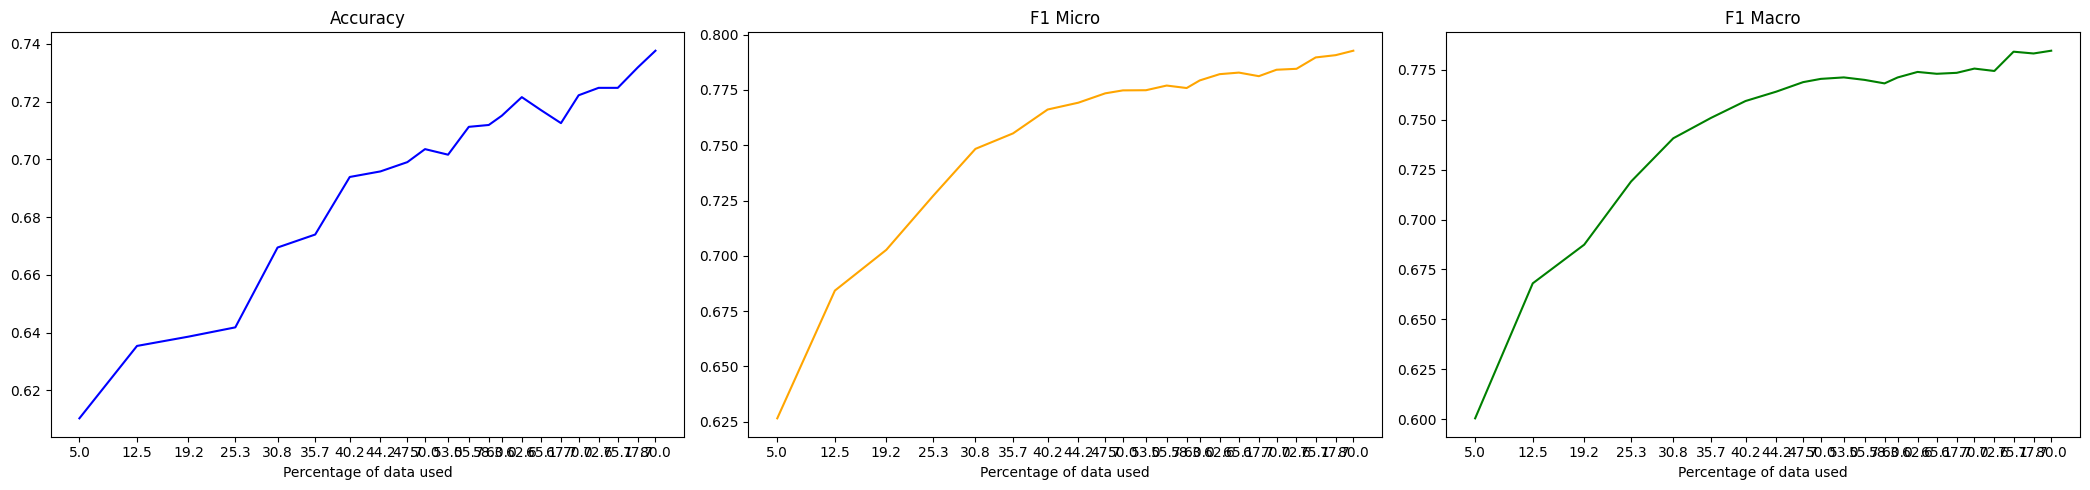

In [20]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: nicost918 (nicost918-petra-christian-university). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241218_035041-0c14e40a
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results/netifier-lc-4
wandb: ⭐️ View project at https://wandb.ai/nicost918-petra-christian-university/huggingface
wandb: 🚀 View run at https://wandb.

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.463594,0.462379,0.975610,0.030166,0.058522,0.049751
2,No log,0.391793,0.568489,0.831081,0.278281,0.416949,0.340929
3,No log,0.357158,0.562701,0.873684,0.250377,0.389215,0.305181
4,No log,0.331397,0.590354,0.783858,0.432127,0.557122,0.487882
5,No log,0.317543,0.603215,0.790637,0.458522,0.580430,0.516101
6,No log,0.307228,0.619293,0.780571,0.515083,0.620627,0.590389
7,No log,0.304412,0.622508,0.775442,0.528658,0.628700,0.586116
8,No log,0.301726,0.622508,0.763407,0.547511,0.637681,0.605725
9,No log,0.302151,0.625723,0.764644,0.551282,0.640666,0.610989
10,No log,0.300772,0.628939,0.751984,0.571644,0.649529,0.626356


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.76      0.84       362
                sara       0.70      0.31      0.43       237
         radikalisme       0.65      0.62      0.63       235
pencemaran_nama_baik       0.68      0.53      0.60       492

           micro avg       0.75      0.57      0.65      1326
           macro avg       0.74      0.56      0.63      1326
        weighted avg       0.75      0.57      0.64      1326
         samples avg       0.35      0.33      0.33      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.6289389067524116, F1 Micro: 0.6495287060839761, F1 Macro: 0.626355645176144
                      precision    recall  f1-score   support

          pornografi       0.93      0.76      0.84       362
                sara       0.70      0.31      0.43       237
         radikalisme       0.65      0.62      0.63       235
pencemaran_nama_baik       0.68      0.53      0.60       492

           micro avg       0.75      0.57      0.65      1326
           macro avg       0.74      0.56      0.63      1326
        weighted avg       0.75      0.57      0.64      1326
         samples avg       0.35      0.33      0.33      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.8938983887434007
Samples above threshold: 583
Acquired samples: 583
Sampling duration: 19.815344095230103 seconds
New train size: 971


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.444130,0.502251,1.000000,0.104827,0.189761,0.138723
2,No log,0.330863,0.576206,0.797357,0.409502,0.541106,0.473706
3,No log,0.301122,0.632797,0.748555,0.585973,0.657360,0.630764
4,No log,0.315555,0.613505,0.776190,0.491704,0.602031,0.581193
5,No log,0.299027,0.625080,0.692654,0.696833,0.694737,0.676591
6,No log,0.305990,0.639871,0.718227,0.647813,0.681205,0.665327
7,No log,0.309180,0.632154,0.726098,0.635747,0.677925,0.661940
8,No log,0.318195,0.625080,0.710098,0.657617,0.682850,0.663449
9,0.153600,0.321354,0.633441,0.722269,0.643288,0.680495,0.665551
10,0.153600,0.322750,0.633441,0.716903,0.649321,0.681440,0.666858


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.79      0.84       362
                sara       0.64      0.51      0.57       237
         radikalisme       0.58      0.63      0.60       235
pencemaran_nama_baik       0.65      0.75      0.69       492

           micro avg       0.69      0.70      0.69      1326
           macro avg       0.69      0.67      0.68      1326
        weighted avg       0.70      0.70      0.70      1326
         samples avg       0.39      0.39      0.38      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 971: Accuracy: 0.62508038585209, F1 Micro: 0.6947368421052631, F1 Macro: 0.6765913030860169
                      precision    recall  f1-score   support

          pornografi       0.90      0.79      0.84       362
                sara       0.64      0.51      0.57       237
         radikalisme       0.58      0.63      0.60       235
pencemaran_nama_baik       0.65      0.75      0.69       492

           micro avg       0.69      0.70      0.69      1326
           macro avg       0.69      0.67      0.68      1326
        weighted avg       0.70      0.70      0.70      1326
         samples avg       0.39      0.39      0.38      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.9036853894591333
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 17.85330605506897 seconds
New train size: 1496


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.416357,0.549196,0.960870,0.166667,0.284062,0.201475
2,No log,0.310296,0.620579,0.776271,0.518100,0.621438,0.598352
3,No log,0.308178,0.630868,0.685535,0.657617,0.671286,0.668668
4,No log,0.292395,0.643730,0.719967,0.655354,0.686143,0.672406
5,No log,0.297415,0.646302,0.730964,0.651584,0.688995,0.679137
6,0.150100,0.327460,0.630225,0.650754,0.781297,0.710075,0.706530
7,0.150100,0.322523,0.639871,0.676630,0.751131,0.711937,0.703559
8,0.150100,0.325789,0.646945,0.737118,0.636501,0.683124,0.666735
9,0.150100,0.329062,0.644373,0.713496,0.681750,0.697262,0.687439
10,0.150100,0.329809,0.643730,0.708270,0.697587,0.702888,0.694133


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.87      0.84      0.85       362
                sara       0.57      0.57      0.57       237
         radikalisme       0.61      0.83      0.71       235
pencemaran_nama_baik       0.64      0.74      0.68       492

           micro avg       0.68      0.75      0.71      1326
           macro avg       0.67      0.74      0.70      1326
        weighted avg       0.68      0.75      0.71      1326
         samples avg       0.42      0.43      0.41      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1496: Accuracy: 0.639871382636656, F1 Micro: 0.7119370979270907, F1 Macro: 0.7035591122963345
                      precision    recall  f1-score   support

          pornografi       0.87      0.84      0.85       362
                sara       0.57      0.57      0.57       237
         radikalisme       0.61      0.83      0.71       235
pencemaran_nama_baik       0.64      0.74      0.68       492

           micro avg       0.68      0.75      0.71      1326
           macro avg       0.67      0.74      0.70      1326
        weighted avg       0.68      0.75      0.71      1326
         samples avg       0.42      0.43      0.41      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.8686201184988026
Samples above threshold: 473
Acquired samples: 473
Sampling duration: 16.096834182739258 seconds
New train size: 1969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.356887,0.567846,0.882653,0.260935,0.402794,0.292652
2,No log,0.301741,0.627010,0.770742,0.532428,0.629795,0.616624
3,No log,0.322707,0.600000,0.605490,0.848416,0.706658,0.704701
4,No log,0.292754,0.638585,0.679452,0.748115,0.712132,0.711098
5,0.167200,0.298174,0.641158,0.683578,0.772247,0.725212,0.723104
6,0.167200,0.306122,0.652090,0.705219,0.754148,0.728863,0.724491
7,0.167200,0.304110,0.660450,0.725490,0.725490,0.725490,0.720419
8,0.167200,0.312404,0.664309,0.719273,0.745852,0.732321,0.729324
9,0.067400,0.321894,0.659164,0.703266,0.763198,0.732007,0.728200
10,0.067400,0.325584,0.659164,0.702759,0.768477,0.734150,0.730330


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.87      0.87      0.87       362
                sara       0.61      0.65      0.63       237
         radikalisme       0.67      0.82      0.73       235
pencemaran_nama_baik       0.65      0.73      0.69       492

           micro avg       0.70      0.77      0.73      1326
           macro avg       0.70      0.77      0.73      1326
        weighted avg       0.71      0.77      0.74      1326
         samples avg       0.42      0.44      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1969: Accuracy: 0.6591639871382636, F1 Micro: 0.734149855907781, F1 Macro: 0.7303303425644769
                      precision    recall  f1-score   support

          pornografi       0.87      0.87      0.87       362
                sara       0.61      0.65      0.63       237
         radikalisme       0.67      0.82      0.73       235
pencemaran_nama_baik       0.65      0.73      0.69       492

           micro avg       0.70      0.77      0.73      1326
           macro avg       0.70      0.77      0.73      1326
        weighted avg       0.71      0.77      0.74      1326
         samples avg       0.42      0.44      0.42      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.8139048308134079
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 14.540822744369507 seconds
New train size: 2394


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.372898,0.561415,0.957529,0.187029,0.312934,0.218234
2,No log,0.301439,0.615434,0.824611,0.439668,0.573537,0.544169
3,No log,0.267420,0.654662,0.770985,0.637255,0.697770,0.687884
4,0.187900,0.272416,0.657235,0.756345,0.674208,0.712919,0.699861
5,0.187900,0.283523,0.652090,0.714689,0.763198,0.738147,0.729857
6,0.187900,0.288519,0.666881,0.725899,0.760935,0.743004,0.736651
7,0.088600,0.306019,0.661093,0.712989,0.769985,0.740392,0.737029
8,0.088600,0.309596,0.672026,0.717227,0.788084,0.750988,0.745471
9,0.088600,0.321098,0.670740,0.711111,0.796380,0.751334,0.745432
10,0.050600,0.318144,0.668810,0.718125,0.785822,0.750450,0.746274


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.88      0.88      0.88       362
                sara       0.61      0.69      0.65       237
         radikalisme       0.67      0.80      0.73       235
pencemaran_nama_baik       0.67      0.78      0.72       492

           micro avg       0.71      0.80      0.75      1326
           macro avg       0.71      0.79      0.75      1326
        weighted avg       0.72      0.80      0.75      1326
         samples avg       0.43      0.45      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2394: Accuracy: 0.6707395498392283, F1 Micro: 0.7513340448239061, F1 Macro: 0.745432261171179
                      precision    recall  f1-score   support

          pornografi       0.88      0.88      0.88       362
                sara       0.61      0.69      0.65       237
         radikalisme       0.67      0.80      0.73       235
pencemaran_nama_baik       0.67      0.78      0.72       492

           micro avg       0.71      0.80      0.75      1326
           macro avg       0.71      0.79      0.75      1326
        weighted avg       0.72      0.80      0.75      1326
         samples avg       0.43      0.45      0.43      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.5137405484914781
Samples above threshold: 383
Acquired samples: 383
Sampling duration: 13.075809478759766 seconds
New train size: 2777


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.339968,0.579421,0.867965,0.302413,0.448546,0.363854
2,No log,0.277708,0.645659,0.762257,0.621418,0.684670,0.672838
3,0.210300,0.269053,0.675884,0.711923,0.779035,0.743968,0.738645
4,0.210300,0.268142,0.666238,0.726748,0.760181,0.743089,0.733001
5,0.210300,0.272136,0.667524,0.752404,0.708145,0.729604,0.712354
6,0.107500,0.291127,0.662379,0.739535,0.719457,0.729358,0.714616
7,0.107500,0.303268,0.668810,0.703412,0.808446,0.752281,0.746659
8,0.107500,0.312357,0.664309,0.705607,0.797134,0.748584,0.741595
9,0.060300,0.314505,0.669453,0.706851,0.809201,0.754571,0.749414
10,0.060300,0.315821,0.668167,0.710438,0.795626,0.750623,0.744643


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.88      0.89      0.89       362
                sara       0.59      0.69      0.64       237
         radikalisme       0.69      0.83      0.75       235
pencemaran_nama_baik       0.66      0.80      0.72       492

           micro avg       0.71      0.81      0.75      1326
           macro avg       0.71      0.80      0.75      1326
        weighted avg       0.71      0.81      0.76      1326
         samples avg       0.44      0.46      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2777: Accuracy: 0.6694533762057878, F1 Micro: 0.7545710267229255, F1 Macro: 0.7494140056784451
                      precision    recall  f1-score   support

          pornografi       0.88      0.89      0.89       362
                sara       0.59      0.69      0.64       237
         radikalisme       0.69      0.83      0.75       235
pencemaran_nama_baik       0.66      0.80      0.72       492

           micro avg       0.71      0.81      0.75      1326
           macro avg       0.71      0.80      0.75      1326
        weighted avg       0.71      0.81      0.76      1326
         samples avg       0.44      0.46      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.21468675136566162
Samples above threshold: 345
Acquired samples: 345
Sampling duration: 11.824037313461304 seconds
New train size: 3122


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.329788,0.566559,0.916418,0.231523,0.369657,0.301617
2,No log,0.267343,0.662379,0.719942,0.754148,0.736648,0.729596
3,0.230800,0.255544,0.678457,0.723994,0.787330,0.754335,0.747537
4,0.230800,0.268451,0.682958,0.709197,0.825792,0.763066,0.759910
5,0.230800,0.283625,0.690032,0.722517,0.822775,0.769394,0.765667
6,0.122900,0.314563,0.684244,0.696049,0.863499,0.770784,0.767642
7,0.122900,0.305070,0.690675,0.719504,0.831825,0.771598,0.769638
8,0.071300,0.314757,0.690675,0.719035,0.831825,0.771329,0.766963
9,0.071300,0.320715,0.686174,0.715667,0.837104,0.771637,0.770978
10,0.071300,0.319182,0.688103,0.720991,0.834087,0.773427,0.770440


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.90       362
                sara       0.60      0.78      0.68       237
         radikalisme       0.69      0.84      0.76       235
pencemaran_nama_baik       0.68      0.82      0.74       492

           micro avg       0.72      0.83      0.77      1326
           macro avg       0.72      0.83      0.77      1326
        weighted avg       0.73      0.83      0.78      1326
         samples avg       0.45      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3122: Accuracy: 0.6881028938906752, F1 Micro: 0.7734265734265735, F1 Macro: 0.7704396634352745
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.90       362
                sara       0.60      0.78      0.68       237
         radikalisme       0.69      0.84      0.76       235
pencemaran_nama_baik       0.68      0.82      0.74       492

           micro avg       0.72      0.83      0.77      1326
           macro avg       0.72      0.83      0.77      1326
        weighted avg       0.73      0.83      0.78      1326
         samples avg       0.45      0.47      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.08390694856643677
Samples above threshold: 310
Acquired samples: 310
Sampling duration: 10.689727544784546 seconds
New train size: 3432


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.305846,0.606431,0.823358,0.425339,0.560915,0.538026
2,No log,0.258356,0.673955,0.744859,0.737557,0.741190,0.739233
3,0.252700,0.255467,0.686174,0.740129,0.777526,0.758367,0.749245
4,0.252700,0.252748,0.695177,0.775237,0.741327,0.757903,0.746809
5,0.142400,0.283485,0.695177,0.709332,0.848416,0.772665,0.768372
6,0.142400,0.289086,0.689389,0.719287,0.821267,0.766901,0.760123
7,0.090300,0.296086,0.699678,0.729602,0.815988,0.770381,0.765589
8,0.090300,0.298215,0.691961,0.743119,0.794118,0.767773,0.759607
9,0.090300,0.312681,0.693248,0.732794,0.819005,0.773504,0.768307
10,0.060700,0.317861,0.695820,0.731987,0.819759,0.773390,0.767841


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.88      0.90       362
                sara       0.62      0.70      0.66       237
         radikalisme       0.72      0.83      0.77       235
pencemaran_nama_baik       0.68      0.83      0.75       492

           micro avg       0.73      0.82      0.77      1326
           macro avg       0.73      0.81      0.77      1326
        weighted avg       0.74      0.82      0.78      1326
         samples avg       0.45      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3432: Accuracy: 0.6932475884244373, F1 Micro: 0.7735042735042735, F1 Macro: 0.7683068804264714
                      precision    recall  f1-score   support

          pornografi       0.92      0.88      0.90       362
                sara       0.62      0.70      0.66       237
         radikalisme       0.72      0.83      0.77       235
pencemaran_nama_baik       0.68      0.83      0.75       492

           micro avg       0.73      0.82      0.77      1326
           macro avg       0.73      0.81      0.77      1326
        weighted avg       0.74      0.82      0.78      1326
         samples avg       0.45      0.47      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.048078835010528564
Samples above threshold: 279
Acquired samples: 279
Sampling duration: 9.60176396369934 seconds
New train size: 3711


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.346357,0.539550,0.894737,0.217949,0.350515,0.323555
2,No log,0.249285,0.691961,0.763911,0.724736,0.743808,0.739347
3,0.268900,0.248848,0.677170,0.759563,0.733786,0.746452,0.731111
4,0.268900,0.259507,0.693248,0.729748,0.808446,0.767084,0.758418
5,0.165200,0.269100,0.696463,0.743825,0.794872,0.768502,0.763066
6,0.165200,0.287766,0.689389,0.726902,0.806938,0.764832,0.758896
7,0.107900,0.285713,0.704180,0.749284,0.788839,0.768553,0.759156
8,0.107900,0.306400,0.701608,0.731233,0.822775,0.774308,0.770346
9,0.075100,0.302738,0.700322,0.745763,0.796380,0.770241,0.760361
10,0.075100,0.314379,0.697106,0.735213,0.806184,0.769065,0.762808


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.88      0.90       362
                sara       0.60      0.74      0.66       237
         radikalisme       0.71      0.85      0.77       235
pencemaran_nama_baik       0.70      0.80      0.75       492

           micro avg       0.73      0.82      0.77      1326
           macro avg       0.73      0.82      0.77      1326
        weighted avg       0.74      0.82      0.78      1326
         samples avg       0.45      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3711: Accuracy: 0.7016077170418007, F1 Micro: 0.7743080198722498, F1 Macro: 0.7703455518757695
                      precision    recall  f1-score   support

          pornografi       0.92      0.88      0.90       362
                sara       0.60      0.74      0.66       237
         radikalisme       0.71      0.85      0.77       235
pencemaran_nama_baik       0.70      0.80      0.75       492

           micro avg       0.73      0.82      0.77      1326
           macro avg       0.73      0.82      0.77      1326
        weighted avg       0.74      0.82      0.78      1326
         samples avg       0.45      0.47      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.03217780590057375
Samples above threshold: 251
Acquired samples: 175
Sampling duration: 8.778464317321777 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.296707,0.645659,0.724165,0.687029,0.705108,0.697085
2,No log,0.248424,0.693891,0.782933,0.712670,0.746151,0.740468
3,0.284200,0.247733,0.697749,0.755390,0.766214,0.760764,0.753469
4,0.284200,0.251726,0.704823,0.755814,0.784314,0.769800,0.765568
5,0.174500,0.277662,0.686817,0.717685,0.841629,0.774731,0.772780
6,0.174500,0.281616,0.691318,0.739792,0.806184,0.771563,0.762986
7,0.116300,0.288267,0.703537,0.744990,0.812971,0.777497,0.771858
8,0.116300,0.325578,0.693248,0.713203,0.851433,0.776212,0.772690
9,0.081400,0.313053,0.708039,0.736388,0.836350,0.783192,0.779963
10,0.081400,0.312386,0.706109,0.742045,0.826546,0.782019,0.778036


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.62      0.75      0.68       237
         radikalisme       0.70      0.86      0.78       235
pencemaran_nama_baik       0.69      0.81      0.75       492

           micro avg       0.74      0.84      0.78      1326
           macro avg       0.74      0.83      0.78      1326
        weighted avg       0.75      0.84      0.79      1326
         samples avg       0.45      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.7080385852090032, F1 Micro: 0.7831920903954803, F1 Macro: 0.779962823685988
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.62      0.75      0.68       237
         radikalisme       0.70      0.86      0.78       235
pencemaran_nama_baik       0.69      0.81      0.75       492

           micro avg       0.74      0.84      0.78      1326
           macro avg       0.74      0.83      0.78      1326
        weighted avg       0.75      0.84      0.79      1326
         samples avg       0.45      0.47      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.016597557067871103
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 8.072646617889404 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.278466,0.661736,0.790766,0.607089,0.686860,0.679124
2,0.290800,0.245998,0.693248,0.806335,0.671946,0.733032,0.722982
3,0.290800,0.238193,0.703537,0.776990,0.743590,0.759923,0.748016
4,0.182200,0.242791,0.713183,0.785884,0.747360,0.766138,0.755682
5,0.182200,0.271864,0.698392,0.728620,0.815988,0.769833,0.767973
6,0.122000,0.265992,0.718328,0.783282,0.763198,0.773109,0.763650
7,0.122000,0.285968,0.713183,0.756776,0.800151,0.777859,0.771204
8,0.085200,0.305961,0.708039,0.736382,0.825792,0.778528,0.773975
9,0.085200,0.308062,0.708682,0.742069,0.811463,0.775216,0.767453
10,0.064900,0.310883,0.708682,0.742561,0.809201,0.774450,0.767217


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.61      0.70      0.65       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.68      0.83      0.75       492

           micro avg       0.74      0.83      0.78      1326
           macro avg       0.74      0.82      0.77      1326
        weighted avg       0.75      0.83      0.78      1326
         samples avg       0.46      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.7080385852090032, F1 Micro: 0.7785282616423747, F1 Macro: 0.773975022289337
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.61      0.70      0.65       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.68      0.83      0.75       492

           micro avg       0.74      0.83      0.78      1326
           macro avg       0.74      0.82      0.77      1326
        weighted avg       0.75      0.83      0.78      1326
         samples avg       0.46      0.47      0.46      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.013437092304229735
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 7.299011945724487 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.275942,0.657878,0.710469,0.742081,0.725931,0.723585
2,0.297500,0.241657,0.697106,0.769110,0.736048,0.752216,0.743413
3,0.297500,0.240947,0.715756,0.754075,0.802413,0.777494,0.769531
4,0.191300,0.251446,0.697106,0.736916,0.796380,0.765495,0.757905
5,0.191300,0.263967,0.705466,0.752340,0.788084,0.769797,0.761391
6,0.132900,0.281507,0.708682,0.750000,0.796380,0.772495,0.766479
7,0.132900,0.302138,0.700322,0.734014,0.813725,0.771817,0.765081
8,0.092300,0.304931,0.708682,0.747857,0.789593,0.768158,0.759720
9,0.092300,0.316380,0.704823,0.735616,0.809955,0.770998,0.763768
10,0.070200,0.317713,0.704823,0.740278,0.803922,0.770788,0.764104


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.88      0.90       362
                sara       0.66      0.64      0.65       237
         radikalisme       0.71      0.86      0.78       235
pencemaran_nama_baik       0.71      0.80      0.75       492

           micro avg       0.75      0.80      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.46      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.7157556270096463, F1 Micro: 0.7774936061381074, F1 Macro: 0.769530932410716
                      precision    recall  f1-score   support

          pornografi       0.92      0.88      0.90       362
                sara       0.66      0.64      0.65       237
         radikalisme       0.71      0.86      0.78       235
pencemaran_nama_baik       0.71      0.80      0.75       492

           micro avg       0.75      0.80      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.46      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.09872881770133972
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 6.590763092041016 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.271003,0.661093,0.742292,0.708145,0.724817,0.719587
2,0.308400,0.245221,0.697106,0.732365,0.798643,0.764069,0.759462
3,0.308400,0.238398,0.697749,0.769112,0.751131,0.760015,0.752545
4,0.198400,0.242466,0.702894,0.757598,0.770739,0.764112,0.756729
5,0.198400,0.255189,0.705466,0.755334,0.800905,0.777452,0.770950
6,0.144200,0.271203,0.705466,0.744105,0.809201,0.775289,0.768449
7,0.144200,0.284810,0.709968,0.754110,0.795626,0.774312,0.767228
8,0.102200,0.292214,0.710611,0.758321,0.790347,0.774003,0.767107
9,0.076200,0.301002,0.708682,0.757971,0.788839,0.773097,0.766703
10,0.076200,0.310449,0.706752,0.752307,0.799397,0.775137,0.769103


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.76      0.81      0.79       235
pencemaran_nama_baik       0.70      0.79      0.74       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.7054662379421222, F1 Micro: 0.7774524158125915, F1 Macro: 0.7709502906666368
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.76      0.81      0.79       235
pencemaran_nama_baik       0.70      0.79      0.74       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.026171576976776113
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 5.9936583042144775 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.271038,0.672026,0.789084,0.643288,0.708766,0.697079
2,0.308600,0.244173,0.696463,0.801587,0.685520,0.739024,0.731228
3,0.308600,0.236142,0.704823,0.782362,0.729261,0.754879,0.747108
4,0.207700,0.245565,0.705466,0.740843,0.808446,0.773170,0.768011
5,0.207700,0.258603,0.711254,0.760088,0.781297,0.770547,0.761380
6,0.151500,0.277540,0.706752,0.745595,0.797888,0.770856,0.763548
7,0.107100,0.289042,0.715113,0.750704,0.803922,0.776402,0.771793
8,0.107100,0.286634,0.708682,0.775969,0.754902,0.765291,0.754597
9,0.080500,0.297916,0.715756,0.765926,0.779789,0.772795,0.764226
10,0.080500,0.309868,0.714469,0.748432,0.809955,0.777979,0.772118


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.63      0.68      0.66       237
         radikalisme       0.72      0.84      0.78       235
pencemaran_nama_baik       0.70      0.78      0.74       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.7144694533762058, F1 Micro: 0.7779789931184354, F1 Macro: 0.7721179125209016
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.63      0.68      0.66       237
         radikalisme       0.72      0.84      0.78       235
pencemaran_nama_baik       0.70      0.78      0.74       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.011598050594329834
Samples above threshold: 161
Acquired samples: 200
Sampling duration: 5.464770078659058 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.260304,0.675241,0.750781,0.724736,0.737529,0.732946
2,0.305400,0.237471,0.699678,0.758775,0.766214,0.762477,0.754745
3,0.305400,0.228880,0.708682,0.768999,0.770739,0.769868,0.763655
4,0.203300,0.245126,0.704180,0.731025,0.828054,0.776521,0.772117
5,0.152300,0.245055,0.722186,0.785004,0.773756,0.779339,0.767365
6,0.152300,0.261837,0.711254,0.765522,0.790347,0.777737,0.769908
7,0.108700,0.283090,0.708039,0.748945,0.803167,0.775109,0.769704
8,0.108700,0.302606,0.713826,0.739042,0.826546,0.780349,0.775836
9,0.085000,0.301425,0.714469,0.747911,0.809955,0.777697,0.770598
10,0.067400,0.302546,0.718328,0.752801,0.810709,0.780683,0.774559


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.62      0.68      0.65       237
         radikalisme       0.74      0.84      0.78       235
pencemaran_nama_baik       0.71      0.78      0.75       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.7183279742765273, F1 Micro: 0.7806826434277414, F1 Macro: 0.774559325331042
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.62      0.68      0.65       237
         radikalisme       0.74      0.84      0.78       235
pencemaran_nama_baik       0.71      0.78      0.75       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.004984986782073975
Samples above threshold: 136
Acquired samples: 200
Sampling duration: 4.775598764419556 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.259149,0.670096,0.750796,0.711161,0.730442,0.725570
2,0.306500,0.236169,0.693891,0.756496,0.768477,0.762439,0.758265
3,0.306500,0.232303,0.708039,0.758646,0.794118,0.775976,0.772643
4,0.206700,0.238710,0.715756,0.775094,0.774510,0.774802,0.766040
5,0.148600,0.277349,0.703537,0.716380,0.847662,0.776511,0.772144
6,0.148600,0.273679,0.709968,0.748428,0.807692,0.776931,0.767411
7,0.112900,0.307729,0.715113,0.734127,0.837104,0.782241,0.776384
8,0.083500,0.295700,0.713183,0.760059,0.783560,0.771630,0.763172
9,0.083500,0.308554,0.714469,0.751933,0.806938,0.778465,0.770108
10,0.065200,0.306616,0.716399,0.762491,0.794118,0.777983,0.770183


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.93      0.91       362
                sara       0.61      0.72      0.66       237
         radikalisme       0.70      0.88      0.78       235
pencemaran_nama_baik       0.71      0.81      0.75       492

           micro avg       0.73      0.84      0.78      1326
           macro avg       0.73      0.83      0.78      1326
        weighted avg       0.74      0.84      0.78      1326
         samples avg       0.46      0.48      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.715112540192926, F1 Micro: 0.7822410147991543, F1 Macro: 0.7763837491561971
                      precision    recall  f1-score   support

          pornografi       0.90      0.93      0.91       362
                sara       0.61      0.72      0.66       237
         radikalisme       0.70      0.88      0.78       235
pencemaran_nama_baik       0.71      0.81      0.75       492

           micro avg       0.73      0.84      0.78      1326
           macro avg       0.73      0.83      0.78      1326
        weighted avg       0.74      0.84      0.78      1326
         samples avg       0.46      0.48      0.46      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.004929125308990482
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 4.120500326156616 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.250613,0.682958,0.784753,0.659879,0.716919,0.710446
2,0.301800,0.235575,0.699035,0.833969,0.659125,0.736310,0.716609
3,0.301800,0.222461,0.714469,0.785039,0.751885,0.768105,0.755892
4,0.203900,0.240357,0.709325,0.752131,0.798643,0.774689,0.769071
5,0.149400,0.263847,0.703537,0.740358,0.810709,0.773938,0.769198
6,0.149400,0.285546,0.699035,0.733468,0.819759,0.774217,0.768827
7,0.113300,0.277339,0.715113,0.766889,0.779035,0.772914,0.767923
8,0.082400,0.296166,0.702251,0.746469,0.797134,0.770970,0.762525
9,0.082400,0.303264,0.707395,0.754703,0.786576,0.770310,0.763222
10,0.067600,0.303320,0.706109,0.759410,0.776018,0.767624,0.758361


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.61      0.70      0.65       237
         radikalisme       0.71      0.86      0.78       235
pencemaran_nama_baik       0.74      0.74      0.74       492

           micro avg       0.75      0.80      0.77      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.7093247588424437, F1 Micro: 0.7746891002194586, F1 Macro: 0.7690709121958127
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.61      0.70      0.65       237
         radikalisme       0.71      0.86      0.78       235
pencemaran_nama_baik       0.74      0.74      0.74       492

           micro avg       0.75      0.80      0.77      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.021856379508972176
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 3.560370683670044 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.260514,0.670740,0.844519,0.569382,0.680180,0.674237
2,0.304600,0.228957,0.702894,0.765101,0.773756,0.769404,0.759324
3,0.211600,0.230210,0.718328,0.788263,0.749623,0.768458,0.752319
4,0.211600,0.234236,0.722186,0.783721,0.762443,0.772936,0.757771
5,0.151500,0.255873,0.718971,0.800165,0.730769,0.763894,0.746877
6,0.118100,0.269553,0.712540,0.764355,0.773002,0.768654,0.756279
7,0.118100,0.292946,0.714469,0.751927,0.809201,0.779513,0.773386
8,0.086800,0.301430,0.712540,0.759178,0.779789,0.769345,0.759192
9,0.072300,0.307682,0.717042,0.761561,0.794872,0.777860,0.768610
10,0.072300,0.309267,0.717685,0.764103,0.786576,0.775177,0.765968


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.62      0.68      0.65       237
         radikalisme       0.72      0.86      0.78       235
pencemaran_nama_baik       0.72      0.76      0.74       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.7144694533762058, F1 Micro: 0.7795132582637123, F1 Macro: 0.7733857083111553
                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.62      0.68      0.65       237
         radikalisme       0.72      0.86      0.78       235
pencemaran_nama_baik       0.72      0.76      0.74       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.0035712480545043944
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 2.8612165451049805 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.248241,0.698392,0.742402,0.773756,0.757755,0.751358
2,0.301200,0.233004,0.708039,0.773865,0.745852,0.759601,0.747573
3,0.210300,0.233211,0.709968,0.757465,0.784314,0.770656,0.759125
4,0.210300,0.238960,0.720257,0.779803,0.774510,0.777147,0.763838
5,0.150000,0.252859,0.718971,0.790476,0.751131,0.770302,0.760316
6,0.119700,0.265510,0.717042,0.774024,0.777526,0.775771,0.767474
7,0.119700,0.286961,0.714469,0.764275,0.787330,0.775632,0.769176
8,0.087200,0.296542,0.713826,0.767580,0.782051,0.774748,0.767407
9,0.070200,0.312889,0.713826,0.754423,0.803922,0.778386,0.772750
10,0.057800,0.310932,0.713183,0.761043,0.792609,0.776505,0.769470


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.64      0.66      0.65       237
         radikalisme       0.72      0.87      0.79       235
pencemaran_nama_baik       0.71      0.76      0.73       492

           micro avg       0.75      0.80      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.7138263665594855, F1 Micro: 0.7783862723621761, F1 Macro: 0.7727503552930881
                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.64      0.66      0.65       237
         radikalisme       0.72      0.87      0.79       235
pencemaran_nama_baik       0.71      0.76      0.73       492

           micro avg       0.75      0.80      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.0017364263534545897
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 2.196903705596924 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.238873,0.704180,0.770998,0.733786,0.751932,0.740085
2,0.298300,0.224279,0.716399,0.773873,0.763952,0.768880,0.756342
3,0.208600,0.221763,0.713826,0.779491,0.762443,0.770873,0.764985
4,0.208600,0.236642,0.722830,0.785714,0.754902,0.770000,0.762025
5,0.161700,0.257310,0.718971,0.743729,0.827300,0.783292,0.778391
6,0.121300,0.284378,0.711254,0.734119,0.845400,0.785839,0.781491
7,0.094200,0.281181,0.718971,0.758719,0.803922,0.780666,0.775007
8,0.094200,0.298815,0.722186,0.759233,0.806184,0.782004,0.776874
9,0.072200,0.310440,0.719614,0.754730,0.812217,0.782419,0.777120
10,0.060800,0.307316,0.722186,0.764493,0.795626,0.779749,0.773952


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.88      0.93      0.90       362
                sara       0.61      0.75      0.67       237
         radikalisme       0.75      0.84      0.79       235
pencemaran_nama_baik       0.69      0.83      0.76       492

           micro avg       0.73      0.85      0.79      1326
           macro avg       0.73      0.84      0.78      1326
        weighted avg       0.74      0.85      0.79      1326
         samples avg       0.47      0.48      0.47      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.7112540192926045, F1 Micro: 0.7858394672274798, F1 Macro: 0.7814912338292623
                      precision    recall  f1-score   support

          pornografi       0.88      0.93      0.90       362
                sara       0.61      0.75      0.67       237
         radikalisme       0.75      0.84      0.79       235
pencemaran_nama_baik       0.69      0.83      0.76       492

           micro avg       0.73      0.85      0.79      1326
           macro avg       0.73      0.84      0.78      1326
        weighted avg       0.74      0.85      0.79      1326
         samples avg       0.47      0.48      0.47      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.0025656223297119145
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 1.518622636795044 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.241805,0.693248,0.752054,0.759427,0.755722,0.749641
2,0.297300,0.221628,0.714469,0.796721,0.733032,0.763551,0.755578
3,0.202700,0.224762,0.723473,0.768179,0.804676,0.786004,0.777857
4,0.160600,0.234195,0.718971,0.772292,0.790347,0.781215,0.774453
5,0.160600,0.250311,0.727331,0.788253,0.769231,0.778626,0.769889
6,0.116400,0.275191,0.720257,0.766983,0.791855,0.779221,0.771482
7,0.093300,0.279699,0.733119,0.794457,0.778281,0.786286,0.780329
8,0.074000,0.293146,0.729904,0.791056,0.773756,0.782310,0.775500
9,0.074000,0.304958,0.725402,0.775888,0.791101,0.783420,0.779020
10,0.060400,0.311287,0.720900,0.770073,0.795626,0.782641,0.777945


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.70      0.63      0.66       237
         radikalisme       0.78      0.82      0.80       235
pencemaran_nama_baik       0.75      0.73      0.74       492

           micro avg       0.79      0.78      0.79      1326
           macro avg       0.79      0.77      0.78      1326
        weighted avg       0.79      0.78      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7331189710610932, F1 Micro: 0.7862857142857143, F1 Macro: 0.7803286738541613
                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.70      0.63      0.66       237
         radikalisme       0.78      0.82      0.80       235
pencemaran_nama_baik       0.75      0.73      0.74       492

           micro avg       0.79      0.78      0.79      1326
           macro avg       0.79      0.77      0.78      1326
        weighted avg       0.79      0.78      0.79      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.002354919910430908
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 1.058779001235962 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.239418,0.709325,0.815111,0.691554,0.748266,0.738830
2,0.297900,0.228415,0.717042,0.770628,0.767722,0.769173,0.764317
3,0.204000,0.227151,0.724759,0.829749,0.698341,0.758395,0.743603
4,0.160600,0.233192,0.722830,0.768786,0.802413,0.785240,0.776619
5,0.160600,0.254483,0.725402,0.783804,0.773756,0.778748,0.770138
6,0.123800,0.268694,0.719614,0.771300,0.778281,0.774775,0.768213
7,0.090100,0.277132,0.721543,0.786719,0.759427,0.772832,0.763031
8,0.078100,0.294948,0.720257,0.768275,0.792609,0.780252,0.773996
9,0.062100,0.305131,0.717685,0.758351,0.804676,0.780827,0.773910
10,0.062100,0.303606,0.722186,0.769175,0.794118,0.781447,0.774363


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.88      0.91       362
                sara       0.66      0.63      0.64       237
         radikalisme       0.75      0.85      0.79       235
pencemaran_nama_baik       0.72      0.81      0.76       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.7228295819935692, F1 Micro: 0.785239852398524, F1 Macro: 0.7766186751566331
                      precision    recall  f1-score   support

          pornografi       0.94      0.88      0.91       362
                sara       0.66      0.63      0.64       237
         radikalisme       0.75      0.85      0.79       235
pencemaran_nama_baik       0.72      0.81      0.76       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326

Total sampling time: 175.79 seconds
Total runtime: 11324.78699684143 seconds


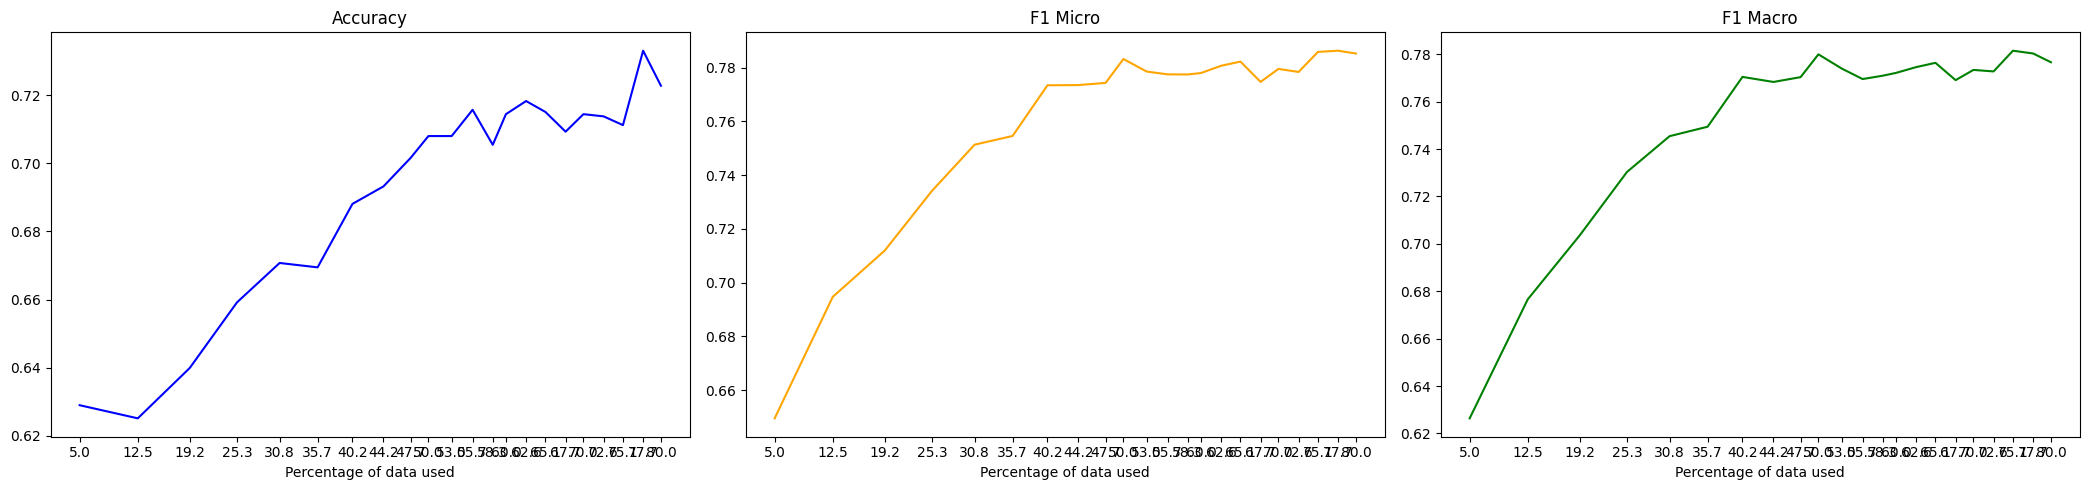

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.458386,0.505466,1.000000,0.080694,0.149337,0.114072
2,No log,0.384749,0.584566,0.914454,0.233786,0.372372,0.251831
3,No log,0.356113,0.571704,0.750000,0.348416,0.475798,0.347973
4,No log,0.330139,0.593569,0.773109,0.416290,0.541176,0.453938
5,No log,0.312512,0.608360,0.758850,0.517345,0.615247,0.548237
6,No log,0.303364,0.628296,0.745247,0.591252,0.659378,0.634356
7,No log,0.297518,0.625080,0.737660,0.608597,0.666942,0.633439
8,No log,0.296958,0.624437,0.752000,0.567119,0.646604,0.609105
9,No log,0.293293,0.627653,0.743662,0.597285,0.662484,0.635006
10,No log,0.293404,0.627653,0.747126,0.588235,0.658228,0.629208


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.83      0.85      0.84       362
                sara       0.72      0.29      0.41       237
         radikalisme       0.72      0.61      0.66       235
pencemaran_nama_baik       0.67      0.59      0.63       492

           micro avg       0.74      0.61      0.67      1326
           macro avg       0.73      0.58      0.63      1326
        weighted avg       0.73      0.61      0.65      1326
         samples avg       0.38      0.35      0.35      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.62508038585209, F1 Micro: 0.6669421487603305, F1 Macro: 0.6334393870554681
                      precision    recall  f1-score   support

          pornografi       0.83      0.85      0.84       362
                sara       0.72      0.29      0.41       237
         radikalisme       0.72      0.61      0.66       235
pencemaran_nama_baik       0.67      0.59      0.63       492

           micro avg       0.74      0.61      0.67      1326
           macro avg       0.73      0.58      0.63      1326
        weighted avg       0.73      0.61      0.65      1326
         samples avg       0.38      0.35      0.35      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.8863574646413328
Samples above threshold: 583
Acquired samples: 583
Sampling duration: 19.84381866455078 seconds
New train size: 971


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.427968,0.553055,0.982609,0.170437,0.290488,0.206246
2,No log,0.332813,0.577492,0.751678,0.422323,0.540802,0.398713
3,No log,0.304915,0.627653,0.715260,0.632730,0.671469,0.645029
4,No log,0.310326,0.600643,0.651329,0.757919,0.700593,0.685260
5,No log,0.302742,0.620579,0.687948,0.723228,0.705147,0.688958
6,No log,0.294074,0.644373,0.739865,0.660633,0.698008,0.682417
7,No log,0.297824,0.646302,0.731489,0.677979,0.703718,0.686638
8,No log,0.296019,0.648232,0.753982,0.642534,0.693811,0.680338
9,0.148300,0.299764,0.655305,0.732806,0.699095,0.715554,0.701088
10,0.148300,0.301377,0.655305,0.738076,0.688537,0.712446,0.697991


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.82      0.88      0.85       362
                sara       0.70      0.52      0.60       237
         radikalisme       0.70      0.66      0.68       235
pencemaran_nama_baik       0.69      0.67      0.68       492

           micro avg       0.73      0.70      0.72      1326
           macro avg       0.73      0.68      0.70      1326
        weighted avg       0.73      0.70      0.71      1326
         samples avg       0.39      0.39      0.38      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 971: Accuracy: 0.6553054662379422, F1 Micro: 0.7155538402161328, F1 Macro: 0.701088411334796
                      precision    recall  f1-score   support

          pornografi       0.82      0.88      0.85       362
                sara       0.70      0.52      0.60       237
         radikalisme       0.70      0.66      0.68       235
pencemaran_nama_baik       0.69      0.67      0.68       492

           micro avg       0.73      0.70      0.72      1326
           macro avg       0.73      0.68      0.70      1326
        weighted avg       0.73      0.70      0.71      1326
         samples avg       0.39      0.39      0.38      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.9607703499495983
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 17.868242263793945 seconds
New train size: 1496


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.426703,0.558199,0.885993,0.205128,0.333129,0.227925
2,No log,0.334307,0.557556,0.707986,0.447964,0.548730,0.444515
3,No log,0.286290,0.644373,0.747826,0.648567,0.694669,0.675476
4,No log,0.297634,0.636656,0.764067,0.583710,0.661821,0.622625
5,No log,0.286399,0.636656,0.703170,0.736048,0.719234,0.702375
6,0.155900,0.302381,0.643087,0.675727,0.806184,0.735213,0.726249
7,0.155900,0.289574,0.661736,0.729323,0.731523,0.730422,0.718552
8,0.155900,0.292423,0.654662,0.728302,0.727753,0.728027,0.717911
9,0.155900,0.299407,0.657235,0.721898,0.745852,0.733680,0.723209
10,0.155900,0.297591,0.663666,0.736719,0.711161,0.723715,0.709775


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.79      0.90      0.84       362
                sara       0.58      0.72      0.64       237
         radikalisme       0.66      0.74      0.70       235
pencemaran_nama_baik       0.65      0.81      0.72       492

           micro avg       0.68      0.81      0.74      1326
           macro avg       0.67      0.79      0.73      1326
        weighted avg       0.68      0.81      0.74      1326
         samples avg       0.41      0.45      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1496: Accuracy: 0.6430868167202572, F1 Micro: 0.7352132049518569, F1 Macro: 0.7262493333052836
                      precision    recall  f1-score   support

          pornografi       0.79      0.90      0.84       362
                sara       0.58      0.72      0.64       237
         radikalisme       0.66      0.74      0.70       235
pencemaran_nama_baik       0.65      0.81      0.72       492

           micro avg       0.68      0.81      0.74      1326
           macro avg       0.67      0.79      0.73      1326
        weighted avg       0.68      0.81      0.74      1326
         samples avg       0.41      0.45      0.42      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.8456389755010613
Samples above threshold: 473
Acquired samples: 473
Sampling duration: 16.09619140625 seconds
New train size: 1969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.414244,0.549196,0.786765,0.242081,0.370242,0.248539
2,No log,0.306138,0.596785,0.697617,0.640271,0.667715,0.641205
3,No log,0.288604,0.642444,0.693118,0.744344,0.717818,0.708078
4,No log,0.319901,0.599357,0.631459,0.838612,0.720441,0.714559
5,0.170200,0.284270,0.654019,0.729358,0.719457,0.724374,0.696869
6,0.170200,0.298292,0.662379,0.706757,0.788839,0.745545,0.737611
7,0.170200,0.299499,0.659807,0.736513,0.710407,0.723225,0.710491
8,0.170200,0.315518,0.650161,0.724296,0.717195,0.720728,0.702222
9,0.063800,0.308076,0.664309,0.732236,0.738311,0.735261,0.723701
10,0.063800,0.312946,0.660450,0.726077,0.749623,0.737662,0.726047


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.87      0.88      0.87       362
                sara       0.64      0.66      0.65       237
         radikalisme       0.64      0.79      0.71       235
pencemaran_nama_baik       0.67      0.78      0.72       492

           micro avg       0.71      0.79      0.75      1326
           macro avg       0.70      0.78      0.74      1326
        weighted avg       0.71      0.79      0.75      1326
         samples avg       0.43      0.45      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1969: Accuracy: 0.662379421221865, F1 Micro: 0.7455452601568069, F1 Macro: 0.7376111317034801
                      precision    recall  f1-score   support

          pornografi       0.87      0.88      0.87       362
                sara       0.64      0.66      0.65       237
         radikalisme       0.64      0.79      0.71       235
pencemaran_nama_baik       0.67      0.78      0.72       492

           micro avg       0.71      0.79      0.75      1326
           macro avg       0.70      0.78      0.74      1326
        weighted avg       0.71      0.79      0.75      1326
         samples avg       0.43      0.45      0.43      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.7069373190402986
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 14.5509774684906 seconds
New train size: 2394


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.382465,0.580707,0.927673,0.222474,0.358881,0.238643
2,No log,0.299033,0.619936,0.785068,0.523379,0.628054,0.623398
3,No log,0.275214,0.668167,0.707983,0.762443,0.734205,0.721529
4,0.189000,0.264165,0.672669,0.721546,0.760181,0.740360,0.728775
5,0.189000,0.273975,0.673955,0.721484,0.777526,0.748457,0.736891
6,0.189000,0.310303,0.670740,0.701299,0.814480,0.753664,0.743826
7,0.080400,0.297634,0.672669,0.713311,0.788084,0.748836,0.739449
8,0.080400,0.303504,0.675241,0.733824,0.752640,0.743112,0.727744
9,0.080400,0.310156,0.679100,0.724162,0.782051,0.751994,0.739718
10,0.043000,0.312536,0.680386,0.727594,0.777526,0.751732,0.739727


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.83      0.92      0.88       362
                sara       0.63      0.65      0.64       237
         radikalisme       0.65      0.83      0.73       235
pencemaran_nama_baik       0.67      0.81      0.73       492

           micro avg       0.70      0.81      0.75      1326
           macro avg       0.70      0.80      0.74      1326
        weighted avg       0.70      0.81      0.75      1326
         samples avg       0.44      0.46      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2394: Accuracy: 0.6707395498392283, F1 Micro: 0.7536636427076064, F1 Macro: 0.7438261870651701
                      precision    recall  f1-score   support

          pornografi       0.83      0.92      0.88       362
                sara       0.63      0.65      0.64       237
         radikalisme       0.65      0.83      0.73       235
pencemaran_nama_baik       0.67      0.81      0.73       492

           micro avg       0.70      0.81      0.75      1326
           macro avg       0.70      0.80      0.74      1326
        weighted avg       0.70      0.81      0.75      1326
         samples avg       0.44      0.46      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.4306322515010838
Samples above threshold: 383
Acquired samples: 383
Sampling duration: 13.124965190887451 seconds
New train size: 2777


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.352035,0.509325,0.703349,0.221719,0.337156,0.243792
2,No log,0.286232,0.585852,0.710009,0.625943,0.665331,0.663589
3,0.211800,0.264161,0.668810,0.722865,0.753394,0.737814,0.726587
4,0.211800,0.269960,0.665595,0.709459,0.791855,0.748396,0.741773
5,0.211800,0.299677,0.655949,0.680993,0.848416,0.755541,0.757391
6,0.101200,0.279899,0.685531,0.728778,0.796380,0.761081,0.755233
7,0.101200,0.309913,0.675241,0.702894,0.824284,0.758764,0.754602
8,0.101200,0.310913,0.673955,0.728238,0.776018,0.751369,0.735840
9,0.056400,0.317705,0.674598,0.706339,0.823529,0.760446,0.756798
10,0.056400,0.312450,0.679100,0.723477,0.797134,0.758522,0.752489


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.88      0.89      0.88       362
                sara       0.59      0.70      0.64       237
         radikalisme       0.72      0.81      0.76       235
pencemaran_nama_baik       0.70      0.77      0.73       492

           micro avg       0.73      0.80      0.76      1326
           macro avg       0.72      0.79      0.76      1326
        weighted avg       0.73      0.80      0.76      1326
         samples avg       0.44      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2777: Accuracy: 0.6855305466237942, F1 Micro: 0.761081081081081, F1 Macro: 0.7552333746832414
                      precision    recall  f1-score   support

          pornografi       0.88      0.89      0.88       362
                sara       0.59      0.70      0.64       237
         radikalisme       0.72      0.81      0.76       235
pencemaran_nama_baik       0.70      0.77      0.73       492

           micro avg       0.73      0.80      0.76      1326
           macro avg       0.72      0.79      0.76      1326
        weighted avg       0.73      0.80      0.76      1326
         samples avg       0.44      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.2825503349304199
Samples above threshold: 345
Acquired samples: 345
Sampling duration: 11.821879148483276 seconds
New train size: 3122


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.321035,0.578135,0.850829,0.348416,0.494382,0.426534
2,No log,0.270069,0.655949,0.767668,0.655354,0.707079,0.692626
3,0.233800,0.261947,0.674598,0.704262,0.809955,0.753420,0.743782
4,0.233800,0.262873,0.700965,0.741027,0.794118,0.766655,0.757600
5,0.233800,0.280777,0.697749,0.736370,0.804676,0.769009,0.761634
6,0.123100,0.321600,0.677170,0.682325,0.876320,0.767250,0.766654
7,0.123100,0.308782,0.694534,0.707809,0.847662,0.771448,0.767180
8,0.070300,0.334138,0.692605,0.694833,0.861991,0.769438,0.764882
9,0.070300,0.331058,0.697749,0.707378,0.860483,0.776455,0.772376
10,0.070300,0.320247,0.698392,0.716199,0.846908,0.776088,0.770523


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.88      0.92      0.90       362
                sara       0.59      0.77      0.67       237
         radikalisme       0.69      0.88      0.77       235
pencemaran_nama_baik       0.67      0.85      0.75       492

           micro avg       0.71      0.86      0.78      1326
           macro avg       0.71      0.85      0.77      1326
        weighted avg       0.72      0.86      0.78      1326
         samples avg       0.46      0.49      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3122: Accuracy: 0.6977491961414791, F1 Micro: 0.7764545763865259, F1 Macro: 0.7723763262492246
                      precision    recall  f1-score   support

          pornografi       0.88      0.92      0.90       362
                sara       0.59      0.77      0.67       237
         radikalisme       0.69      0.88      0.77       235
pencemaran_nama_baik       0.67      0.85      0.75       492

           micro avg       0.71      0.86      0.78      1326
           macro avg       0.71      0.85      0.77      1326
        weighted avg       0.72      0.86      0.78      1326
         samples avg       0.46      0.49      0.46      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.05199238657951355
Samples above threshold: 310
Acquired samples: 310
Sampling duration: 10.708080291748047 seconds
New train size: 3432


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.294852,0.629582,0.780320,0.514329,0.620000,0.599359
2,No log,0.261685,0.663023,0.719085,0.758673,0.738349,0.731101
3,0.247700,0.279982,0.655949,0.668824,0.857466,0.751487,0.750520
4,0.247700,0.268081,0.693248,0.713642,0.836350,0.770139,0.766220
5,0.137600,0.297291,0.682958,0.694614,0.855958,0.766892,0.765274
6,0.137600,0.293874,0.702894,0.726081,0.835596,0.776999,0.772322
7,0.081600,0.293623,0.700322,0.737964,0.809201,0.771942,0.763238
8,0.081600,0.321097,0.698392,0.716465,0.849925,0.777509,0.773978
9,0.081600,0.321799,0.701608,0.720871,0.849170,0.779778,0.775766
10,0.054300,0.317891,0.702251,0.726976,0.839367,0.779139,0.775655


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.92      0.91       362
                sara       0.60      0.77      0.68       237
         radikalisme       0.70      0.86      0.77       235
pencemaran_nama_baik       0.68      0.83      0.75       492

           micro avg       0.72      0.85      0.78      1326
           macro avg       0.72      0.84      0.78      1326
        weighted avg       0.73      0.85      0.78      1326
         samples avg       0.46      0.48      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3432: Accuracy: 0.7016077170418007, F1 Micro: 0.7797783933518007, F1 Macro: 0.7757664557123599
                      precision    recall  f1-score   support

          pornografi       0.89      0.92      0.91       362
                sara       0.60      0.77      0.68       237
         radikalisme       0.70      0.86      0.77       235
pencemaran_nama_baik       0.68      0.83      0.75       492

           micro avg       0.72      0.85      0.78      1326
           macro avg       0.72      0.84      0.78      1326
        weighted avg       0.73      0.85      0.78      1326
         samples avg       0.46      0.48      0.46      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.02945581078529358
Samples above threshold: 279
Acquired samples: 279
Sampling duration: 9.607912540435791 seconds
New train size: 3711


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.283954,0.646945,0.760909,0.631222,0.690025,0.669941
2,No log,0.248441,0.689389,0.758065,0.744344,0.751142,0.741043
3,0.262800,0.254324,0.690032,0.714656,0.831071,0.768480,0.764490
4,0.262800,0.254520,0.694534,0.734203,0.806184,0.768512,0.758419
5,0.153100,0.282856,0.691318,0.712276,0.840121,0.770934,0.769265
6,0.153100,0.281662,0.713826,0.729908,0.835596,0.779184,0.776299
7,0.097100,0.306482,0.700322,0.715561,0.846154,0.775397,0.772999
8,0.097100,0.297189,0.708682,0.735294,0.829563,0.779589,0.777531
9,0.064900,0.307553,0.702894,0.732527,0.822021,0.774698,0.769921
10,0.064900,0.316769,0.702251,0.722837,0.837858,0.776109,0.772980


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.91      0.91       362
                sara       0.60      0.76      0.67       237
         radikalisme       0.77      0.82      0.79       235
pencemaran_nama_baik       0.69      0.81      0.74       492

           micro avg       0.74      0.83      0.78      1326
           macro avg       0.74      0.82      0.78      1326
        weighted avg       0.74      0.83      0.78      1326
         samples avg       0.46      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3711: Accuracy: 0.7086816720257235, F1 Micro: 0.7795889440113394, F1 Macro: 0.7775314175931998
                      precision    recall  f1-score   support

          pornografi       0.90      0.91      0.91       362
                sara       0.60      0.76      0.67       237
         radikalisme       0.77      0.82      0.79       235
pencemaran_nama_baik       0.69      0.81      0.74       492

           micro avg       0.74      0.83      0.78      1326
           macro avg       0.74      0.82      0.78      1326
        weighted avg       0.74      0.83      0.78      1326
         samples avg       0.46      0.47      0.46      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.030963277816772466
Samples above threshold: 251
Acquired samples: 175
Sampling duration: 8.736328840255737 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.288462,0.657235,0.778752,0.602564,0.679422,0.674760
2,No log,0.256304,0.679743,0.721958,0.800905,0.759385,0.757940
3,0.275600,0.243234,0.701608,0.777601,0.738311,0.757447,0.744174
4,0.275600,0.255554,0.704180,0.740405,0.800151,0.769119,0.764222
5,0.166600,0.261577,0.704823,0.755474,0.780543,0.767804,0.755705
6,0.166600,0.280001,0.708039,0.743132,0.815988,0.777858,0.774304
7,0.110100,0.299249,0.701608,0.736733,0.806184,0.769896,0.759763
8,0.110100,0.309008,0.703537,0.732347,0.821267,0.774262,0.767521
9,0.076300,0.320895,0.700965,0.722368,0.828054,0.771609,0.767315
10,0.076300,0.314987,0.702251,0.734100,0.818250,0.773894,0.769359


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.91       362
                sara       0.59      0.71      0.65       237
         radikalisme       0.78      0.83      0.80       235
pencemaran_nama_baik       0.70      0.80      0.75       492

           micro avg       0.74      0.82      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.82      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.7080385852090032, F1 Micro: 0.7778576563623293, F1 Macro: 0.7743038877972652
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.91       362
                sara       0.59      0.71      0.65       237
         radikalisme       0.78      0.83      0.80       235
pencemaran_nama_baik       0.70      0.80      0.75       492

           micro avg       0.74      0.82      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.82      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.04432213306427002
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 8.157275199890137 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.280315,0.656592,0.805439,0.580694,0.674847,0.657377
2,0.283700,0.253067,0.688746,0.723702,0.819759,0.768741,0.763600
3,0.283700,0.250598,0.693248,0.748908,0.776018,0.762222,0.746149
4,0.182300,0.255289,0.705466,0.738192,0.825038,0.779202,0.774272
5,0.182300,0.271869,0.706109,0.735709,0.825038,0.777817,0.773449
6,0.119900,0.280563,0.706752,0.747207,0.806938,0.775925,0.770419
7,0.119900,0.298578,0.709325,0.741249,0.814480,0.776141,0.768890
8,0.081700,0.312838,0.702251,0.734050,0.824284,0.776554,0.771819
9,0.081700,0.325384,0.701608,0.724342,0.830317,0.773717,0.767850
10,0.062600,0.314989,0.706752,0.738683,0.812217,0.773707,0.766318


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.87      0.90       362
                sara       0.62      0.70      0.66       237
         radikalisme       0.72      0.86      0.78       235
pencemaran_nama_baik       0.69      0.84      0.76       492

           micro avg       0.74      0.83      0.78      1326
           macro avg       0.74      0.82      0.77      1326
        weighted avg       0.75      0.83      0.78      1326
         samples avg       0.45      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.7054662379421222, F1 Micro: 0.7792022792022791, F1 Macro: 0.7742720098101732
                      precision    recall  f1-score   support

          pornografi       0.93      0.87      0.90       362
                sara       0.62      0.70      0.66       237
         radikalisme       0.72      0.86      0.78       235
pencemaran_nama_baik       0.69      0.84      0.76       492

           micro avg       0.74      0.83      0.78      1326
           macro avg       0.74      0.82      0.77      1326
        weighted avg       0.75      0.83      0.78      1326
         samples avg       0.45      0.47      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.06491667628288268
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 7.40594744682312 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.275365,0.651447,0.750613,0.692308,0.720282,0.705945
2,0.294500,0.243415,0.702251,0.756080,0.773756,0.764816,0.755374
3,0.294500,0.248398,0.691318,0.732830,0.804676,0.767074,0.754195
4,0.188000,0.257163,0.693891,0.729547,0.813725,0.769340,0.765443
5,0.188000,0.263383,0.705466,0.759559,0.779035,0.769173,0.757633
6,0.127600,0.291747,0.709968,0.733333,0.821267,0.774813,0.768330
7,0.127600,0.306246,0.709325,0.733557,0.824284,0.776278,0.771424
8,0.089900,0.311107,0.713183,0.747214,0.809201,0.776973,0.770137
9,0.089900,0.316787,0.711254,0.745669,0.811463,0.777176,0.770627
10,0.066800,0.321378,0.708039,0.741427,0.815234,0.776580,0.770421


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.61      0.70      0.65       237
         radikalisme       0.72      0.82      0.77       235
pencemaran_nama_baik       0.71      0.80      0.75       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.7112540192926045, F1 Micro: 0.7771758757674251, F1 Macro: 0.7706270790620398
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.61      0.70      0.65       237
         radikalisme       0.72      0.82      0.77       235
pencemaran_nama_baik       0.71      0.80      0.75       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.010840308666229247
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 6.673736810684204 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.271653,0.660450,0.825518,0.570890,0.674989,0.660761
2,0.296400,0.241650,0.697749,0.756594,0.757164,0.756879,0.752466
3,0.296400,0.238264,0.706752,0.761522,0.785068,0.773115,0.765064
4,0.195100,0.246694,0.713183,0.778727,0.756410,0.767406,0.760203
5,0.195100,0.275836,0.707395,0.727811,0.834842,0.777661,0.770885
6,0.136300,0.270304,0.715113,0.750526,0.807692,0.778060,0.772348
7,0.136300,0.297487,0.702894,0.729153,0.824284,0.773805,0.767142
8,0.097800,0.302699,0.709325,0.739932,0.817496,0.776783,0.770106
9,0.071500,0.302787,0.714469,0.754623,0.800151,0.776720,0.769708
10,0.071500,0.311985,0.717042,0.748092,0.812971,0.779183,0.772597


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.91      0.91       362
                sara       0.62      0.68      0.65       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.71      0.79      0.75       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.7170418006430869, F1 Micro: 0.7791832309360318, F1 Macro: 0.77259699348055
                      precision    recall  f1-score   support

          pornografi       0.90      0.91      0.91       362
                sara       0.62      0.68      0.65       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.71      0.79      0.75       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.009192407131195068
Samples above threshold: 184
Acquired samples: 133
Sampling duration: 6.001875162124634 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.263670,0.689389,0.766667,0.711161,0.737872,0.731169
2,0.295700,0.236125,0.709968,0.773994,0.754148,0.763942,0.757664
3,0.295700,0.233237,0.713826,0.783217,0.760181,0.771527,0.758110
4,0.194000,0.261103,0.697106,0.721643,0.834842,0.774126,0.767470
5,0.194000,0.264807,0.711897,0.753715,0.803167,0.777656,0.767328
6,0.136300,0.278476,0.715113,0.760059,0.783560,0.771630,0.763061
7,0.094700,0.284777,0.715756,0.759768,0.791855,0.775480,0.766340
8,0.094700,0.301144,0.717685,0.758030,0.800905,0.778878,0.770939
9,0.072000,0.317158,0.709325,0.738806,0.821267,0.777857,0.771032
10,0.072000,0.315488,0.710611,0.748252,0.806938,0.776488,0.770259


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.62      0.67      0.65       237
         radikalisme       0.73      0.83      0.77       235
pencemaran_nama_baik       0.73      0.78      0.75       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.7176848874598071, F1 Micro: 0.7788778877887789, F1 Macro: 0.7709391172546838
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.62      0.67      0.65       237
         radikalisme       0.73      0.83      0.77       235
pencemaran_nama_baik       0.73      0.78      0.75       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.007476878166198731
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 5.496657609939575 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.256831,0.686174,0.777211,0.689291,0.730616,0.728780
2,0.299300,0.231480,0.715113,0.786624,0.745098,0.765298,0.754979
3,0.299300,0.239014,0.708039,0.741168,0.822775,0.779843,0.774901
4,0.202000,0.254895,0.702251,0.739792,0.806184,0.771563,0.759998
5,0.145200,0.269192,0.708682,0.735077,0.826546,0.778133,0.772527
6,0.145200,0.274414,0.720257,0.773196,0.791855,0.782414,0.774938
7,0.098900,0.290995,0.711254,0.766369,0.776772,0.771536,0.760553
8,0.098900,0.299345,0.710611,0.761107,0.788084,0.774361,0.766755
9,0.077400,0.308775,0.713183,0.757948,0.791101,0.774170,0.766842
10,0.062000,0.317721,0.715756,0.749826,0.811463,0.779428,0.773378


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.66      0.65      0.65       237
         radikalisme       0.75      0.84      0.79       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.77      0.79      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.7202572347266881, F1 Micro: 0.782414307004471, F1 Macro: 0.7749378080139446
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.66      0.65      0.65       237
         radikalisme       0.75      0.84      0.79       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.77      0.79      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.010385572910308838
Samples above threshold: 136
Acquired samples: 200
Sampling duration: 4.87216329574585 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.260286,0.682315,0.799815,0.653846,0.719502,0.689558
2,0.301100,0.232983,0.706752,0.758345,0.788084,0.772929,0.766328
3,0.301100,0.230876,0.711897,0.794996,0.742836,0.768031,0.750024
4,0.205300,0.244503,0.712540,0.768882,0.767722,0.768302,0.761606
5,0.146200,0.255422,0.720900,0.778626,0.769231,0.773900,0.762192
6,0.146200,0.272721,0.715756,0.772866,0.764706,0.768764,0.763104
7,0.106100,0.289799,0.713183,0.744976,0.810709,0.776454,0.769506
8,0.080700,0.298990,0.704180,0.749640,0.785822,0.767305,0.758680
9,0.080700,0.306495,0.713826,0.757994,0.786576,0.772021,0.763397
10,0.061500,0.311117,0.717042,0.756429,0.798643,0.776963,0.768139


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.92       362
                sara       0.63      0.65      0.64       237
         radikalisme       0.73      0.82      0.77       235
pencemaran_nama_baik       0.72      0.77      0.74       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.7170418006430869, F1 Micro: 0.776962582538518, F1 Macro: 0.7681386340024651
                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.92       362
                sara       0.63      0.65      0.64       237
         radikalisme       0.73      0.82      0.77       235
pencemaran_nama_baik       0.72      0.77      0.74       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.003636658191680909
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 4.200016021728516 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.248643,0.696463,0.770400,0.726244,0.747671,0.744686
2,0.298500,0.228456,0.717685,0.793435,0.747360,0.769709,0.751073
3,0.298500,0.235249,0.720257,0.757447,0.805430,0.780702,0.772575
4,0.207100,0.234967,0.726045,0.786798,0.782051,0.784418,0.775419
5,0.145300,0.258797,0.715756,0.749653,0.815234,0.781069,0.775890
6,0.145300,0.270647,0.724759,0.782708,0.771493,0.777060,0.769635
7,0.110100,0.295591,0.709325,0.748059,0.799397,0.772876,0.764739
8,0.080000,0.314492,0.707395,0.734322,0.821267,0.775365,0.768583
9,0.080000,0.312838,0.722186,0.758769,0.799397,0.778553,0.771731
10,0.063600,0.317934,0.723473,0.760342,0.803922,0.781525,0.773535


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.91       362
                sara       0.67      0.64      0.66       237
         radikalisme       0.77      0.77      0.77       235
pencemaran_nama_baik       0.74      0.78      0.76       492

           micro avg       0.79      0.78      0.78      1326
           macro avg       0.78      0.77      0.78      1326
        weighted avg       0.79      0.78      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.7260450160771704, F1 Micro: 0.7844175491679274, F1 Macro: 0.7754191380149934
                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.91       362
                sara       0.67      0.64      0.66       237
         radikalisme       0.77      0.77      0.77       235
pencemaran_nama_baik       0.74      0.78      0.76       492

           micro avg       0.79      0.78      0.78      1326
           macro avg       0.78      0.77      0.78      1326
        weighted avg       0.79      0.78      0.79      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.025242233276367192
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 3.575199604034424 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.246259,0.693891,0.757692,0.742836,0.750190,0.743776
2,0.303700,0.227884,0.711897,0.809731,0.702866,0.752523,0.742826
3,0.211800,0.232112,0.724759,0.770290,0.801659,0.785661,0.779243
4,0.211800,0.242884,0.715113,0.759011,0.809955,0.783656,0.775124
5,0.155700,0.252191,0.715756,0.759547,0.809955,0.783942,0.777875
6,0.118500,0.268236,0.720257,0.766618,0.800151,0.783026,0.774604
7,0.118500,0.289832,0.715113,0.757447,0.805430,0.780702,0.772773
8,0.087500,0.297628,0.722830,0.778029,0.779789,0.778908,0.770480
9,0.066800,0.307524,0.717685,0.766715,0.795626,0.780903,0.772452
10,0.066800,0.310822,0.721543,0.762518,0.803922,0.782673,0.774304


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.63      0.69      0.66       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.75      0.76      0.76       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.7247588424437299, F1 Micro: 0.7856614929785662, F1 Macro: 0.779242729488879
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.63      0.69      0.66       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.75      0.76      0.76       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.028077578544616694
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 2.9011476039886475 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.243421,0.702894,0.760722,0.762443,0.761582,0.751727
2,0.308400,0.221513,0.718328,0.780864,0.763198,0.771930,0.763128
3,0.212100,0.234325,0.713826,0.741184,0.840121,0.787557,0.780960
4,0.212100,0.223780,0.721543,0.784954,0.779035,0.781983,0.775052
5,0.160600,0.244736,0.717685,0.755571,0.818250,0.785663,0.778619
6,0.124000,0.265847,0.720900,0.757491,0.819759,0.787396,0.781176
7,0.124000,0.270734,0.726045,0.785606,0.782051,0.783825,0.774204
8,0.092500,0.289742,0.718971,0.766234,0.800905,0.783186,0.776134
9,0.072600,0.297671,0.720257,0.761702,0.809955,0.785088,0.779724
10,0.062300,0.298223,0.724116,0.766382,0.811463,0.788278,0.783265


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.63      0.70      0.67       237
         radikalisme       0.75      0.85      0.80       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.76      0.81      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.7241157556270097, F1 Micro: 0.7882783882783884, F1 Macro: 0.7832649775222131
                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.63      0.70      0.67       237
         radikalisme       0.75      0.85      0.80       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.76      0.81      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.0027696490287780757
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 2.237337112426758 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.242367,0.700965,0.761364,0.757919,0.759637,0.752728
2,0.304100,0.226886,0.710611,0.839925,0.672700,0.747069,0.733255
3,0.208500,0.219536,0.718328,0.797923,0.753394,0.775019,0.764799
4,0.208500,0.224311,0.727331,0.794232,0.768477,0.781142,0.770330
5,0.162700,0.244034,0.723473,0.769121,0.811463,0.789725,0.780449
6,0.119300,0.258141,0.722830,0.765423,0.804676,0.784559,0.780313
7,0.095900,0.275919,0.722830,0.769509,0.803167,0.785978,0.778957
8,0.095900,0.294814,0.722830,0.755230,0.816742,0.784783,0.779271
9,0.072400,0.301076,0.727331,0.759859,0.813725,0.785870,0.780047
10,0.059600,0.297072,0.728617,0.769841,0.804676,0.786873,0.781063


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.92      0.92       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.71      0.86      0.78       235
pencemaran_nama_baik       0.74      0.79      0.76       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.47      0.46      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.7234726688102894, F1 Micro: 0.7897247706422019, F1 Macro: 0.7804488932310327
                      precision    recall  f1-score   support

          pornografi       0.93      0.92      0.92       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.71      0.86      0.78       235
pencemaran_nama_baik       0.74      0.79      0.76       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.47      0.46      0.46      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.004361784458160401
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 1.5323712825775146 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.243555,0.695820,0.746215,0.780543,0.762993,0.756711
2,0.297600,0.220209,0.722830,0.791174,0.757164,0.773796,0.765243
3,0.206100,0.223017,0.718328,0.785824,0.769231,0.777439,0.764751
4,0.160100,0.232690,0.718971,0.771093,0.792609,0.781703,0.775369
5,0.160100,0.241969,0.729904,0.796412,0.769985,0.782975,0.772774
6,0.117100,0.273454,0.713183,0.759312,0.799397,0.778839,0.772216
7,0.091300,0.288842,0.722830,0.754717,0.814480,0.783460,0.777117
8,0.072100,0.295906,0.717042,0.774721,0.785822,0.780232,0.773755
9,0.072100,0.304981,0.721543,0.768390,0.795626,0.781771,0.775013
10,0.057700,0.311975,0.712540,0.754584,0.806938,0.779883,0.774474


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.92      0.92       362
                sara       0.62      0.70      0.66       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.76      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7228295819935692, F1 Micro: 0.7834602829162133, F1 Macro: 0.7771168917422758
                      precision    recall  f1-score   support

          pornografi       0.93      0.92      0.92       362
                sara       0.62      0.70      0.66       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.76      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 0.001691579818725586
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 0.9600405693054199 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.237645,0.708682,0.791980,0.714932,0.751486,0.743326
2,0.293000,0.223919,0.718971,0.778118,0.766968,0.772503,0.761715
3,0.201400,0.225239,0.728617,0.778682,0.793363,0.785954,0.775734
4,0.157800,0.233548,0.726688,0.785714,0.788084,0.786898,0.778815
5,0.157800,0.269131,0.719614,0.759312,0.799397,0.778839,0.770224
6,0.118100,0.264997,0.726688,0.773723,0.799397,0.786350,0.780636
7,0.094100,0.292577,0.720257,0.760454,0.809201,0.784070,0.779704
8,0.071700,0.298632,0.726045,0.768284,0.800151,0.783894,0.779332
9,0.058700,0.304936,0.724116,0.770241,0.796380,0.783092,0.777743
10,0.058700,0.310901,0.726045,0.766618,0.800151,0.783026,0.778287


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.75      0.84      0.79       235
pencemaran_nama_baik       0.76      0.74      0.75       492

           micro avg       0.79      0.79      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.79      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.7266881028938906, F1 Micro: 0.7868975903614458, F1 Macro: 0.7788154584986352
                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.75      0.84      0.79       235
pencemaran_nama_baik       0.76      0.74      0.75       492

           micro avg       0.79      0.79      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.79      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326

Total sampling time: 176.37 seconds
Total runtime: 11369.735578298569 seconds


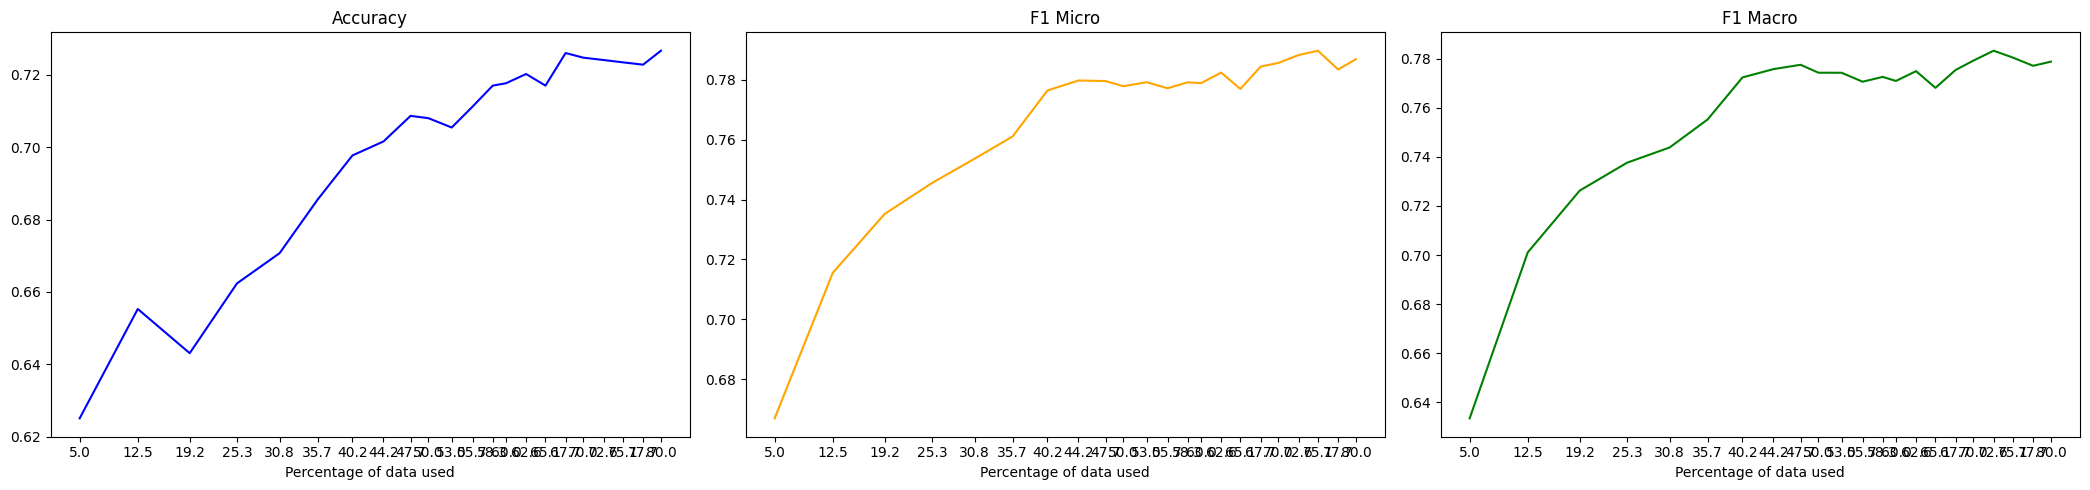

In [ ]:
active_learning(seeds[4], 4)